In [4]:
import numpy as np
import os
import sys
from pprint import pprint
from numpy import sin, cos, pi
import numpy.matlib
import random
from matplotlib import pyplot as plt
from shapely.geometry import Polygon, Point
import shapely.affinity as affinity
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from sklearn.model_selection import train_test_split
import pyomo.environ as pyo
import pyomo.gdp as pyg
from scipy.spatial import ConvexHull
#tf.disable_v2_behavior()  # this line is added to allow placeholder() function to work (does not work in tf2)

In [157]:
plt.rcParams['text.usetex'] = False

#  Generate Data


## Training/Testing Data 

#### Create Data (Affine Transformation)

In [8]:
num_pts = 200
## polygon vertices
poly = Polygon([(1, 1), (4, 1), (4, 4), (1, 4)])
poly2 = Polygon([(2.5, 4.621), (4.624, 2.5), (2.5, 0.3787), (0.3787, 2.5)])  # transformed polygon vertices
x_poly, y_poly = poly.exterior.xy
x_poly2, y_poly2 = poly2.exterior.xy

In [41]:
## generate random points within the input polygon
def random_points_within(pol, num_points):
    min_x, min_y, max_x, max_y = pol.bounds

    gen_points = []

    while len(gen_points) < num_points:
        random_point = Point([random.uniform(min_x, max_x), random.uniform(min_y, max_y)])
        if random_point.within(pol):
            gen_points.append(random_point)

    return gen_points

points_obj = random_points_within(poly, num_pts)
x = np.ones((3, num_pts))     #(x,y,b)

for i in range(num_pts):
    x[0][i] = points_obj[i].x
    x[1][i] = points_obj[i].y


In [10]:
## rotate input points in-place by pi/4 radian
transform1 = np.array([[1, 0, 2.5], [0, 1, 2.5], [0, 0, 1]])  # transformation matrix 1
transform2 = np.array([[1, 0, -2.5], [0, 1, -2.5], [0, 0, 1]])  # transformation matrix 2
rotate = np.array([[cos(pi / 4), -sin(pi / 4), 0], [sin(pi / 4), cos(pi / 4), 0], [0, 0, 1]])  # rotation matrix
y = np.matmul(np.matmul(np.matmul(transform1, rotate), transform2), x)

#### Safe Bound

In [11]:
inp = np.array([[1.25, 3.75, 3.75, 1.25],[1.25, 1.25, 3.75, 3.75],[1, 1 , 1, 1]])
out = np.matmul(np.matmul(np.matmul(transform1, rotate), transform2), inp)
poly3 = Polygon([(out[0, 0], out[1, 0]), (out[0, 1], out[1, 1]), (out[0, 2], out[1, 2]), (out[0, 3], out[1, 3])])

# get the coordinates of the exterior points of the polytope
ex_points = np.array(poly3.exterior.coords)

# get A and b matrices
hull = ConvexHull(ex_points)
eqs = np.array(hull.equations)
A = eqs[0:eqs.shape[0],0:eqs.shape[1]-1]
b = -eqs[0:eqs.shape[0],-1]
print(A)
print(b)
print(ex_points)

[[-0.70710678 -0.70710678]
 [ 0.70710678 -0.70710678]
 [-0.70710678  0.70710678]
 [ 0.70710678  0.70710678]]
[-2.28553391  1.25        1.25        4.78553391]
[[2.5        0.73223305]
 [4.26776695 2.5       ]
 [2.5        4.26776695]
 [0.73223305 2.5       ]
 [2.5        0.73223305]]


#### Plot the Genarated Data 

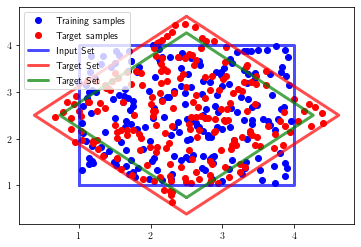

In [7]:
## plot generated data
x_poly3, y_poly3 = poly3.exterior.xy
plt.plot(x[0, :], x[1, :], 'bo', label='Training samples')
plt.plot(y[0, :], y[1, :], 'ro', label='Target samples')
plt.plot(x_poly, y_poly, color='blue', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Input Set')
plt.plot(x_poly2, y_poly2, color='red', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Target Set')
plt.plot(x_poly3, y_poly3, color='green', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Target Set')
plt.legend(loc="upper left")
plt.show()

## reshape input and outputs into column vectors
#x = np.transpose(x[[0, 1], :])
#y = np.transpose(y[[0, 1], :])
x = np.transpose(x)
y = np.transpose(y)

#### Generate data points around the edge

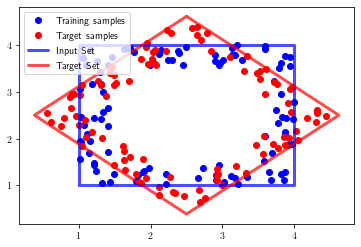

In [8]:
def random_points_edge(poly, num_points, scale = 0.7):
    poly_a = affinity.scale(poly, xfact = scale, yfact = scale)
    gen_points = []
    while len(gen_points) < num_points:
        temp = random_points_within(poly, 1)
        if not temp[0].within(poly_a):
            gen_points.append(temp[0])
    return gen_points

num_points_edge = 100
points_edge = random_points_edge(poly, num_points_edge)
x_edge = np.ones((3, num_points_edge))     #(x,y,b)

for i in range(num_points_edge):
    x_edge[0][i] = points_edge[i].x
    x_edge[1][i] = points_edge[i].y

## rotate input points in-place by pi/4 radian
y_edge = np.matmul(np.matmul(np.matmul(transform1, rotate), transform2), x_edge)
    
## plot generated data
plt.plot(x_edge[0, :], x_edge[1, :], 'bo', label='Training samples')
plt.plot(y_edge[0, :], y_edge[1, :], 'ro', label='Target samples')
plt.plot(x_poly, y_poly, color='blue', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Input Set')
plt.plot(x_poly2, y_poly2, color='red', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Target Set')
plt.legend(loc="upper left")
plt.show()
x_edge = np.transpose(x_edge)
y_edge = np.transpose(y_edge)

In [9]:
x = np.append(x, x_edge,axis = 0)
y = np.append(y, y_edge,axis = 0)

#### Training Mini-Batch Generator

In [10]:
class Batch(object):
    def __init__(self, X_col, Y_col, batch_size_val):
        self.X = X_col
        self.Y = Y_col
        self.size = X_col.shape[0]
        self.train_size = batch_size_val
        self.test_size = self.size - batch_size_val

    def getBatch(self):
        values = range(self.size)
        train_dataset, test_dataset = train_test_split(values, train_size=self.train_size, test_size=self.test_size)
        # indices = np.random.choice(range(self.size), self.batch_size)  # sampling with replacement
        return self.X[train_dataset, :], self.Y[train_dataset, :], self.X[test_dataset, :], self.Y[test_dataset, :]
num_pts = x.shape[0]
batch_size = int(0.7 * num_pts)
batch = Batch(x, y, batch_size)

In [11]:
batch_size

210

# 3-Layer NN

## Build 3-Layer NN Model

Here we setup a 3-layer MLP, with the single hidden layer of ReLU activation and train it with gradient descent optimizer to learn the defined affine transformation from the given data. 
$$
\min_{\mathbf{W}^0,\mathbf{W}^1,\mathbf{W}^2,\mathbf{b}^0,\mathbf{b}^1,\mathbf{b}^2}~~\frac{1}{2}\sum^{N}_{n=1}|| \mathbf{y}(\mathbf{x}^0_n,\mathbf{W}^0,\mathbf{W}^1,\mathbf{b}^0,\mathbf{b}^1)-\mathbf{t}_n||^2_2
$$
$$
\mathbf{W}^0 \mathbf{x}^0 + \mathbf{b}^0 = \mathbf{h}^0
$$
$$
\mathbf{x}^1 = \mathrm{ReLU} (\mathbf{h}^0)
$$
$$
\mathbf{W}^1 \mathbf{x}^1 + \mathbf{b}^1 = \mathbf{h}^1
$$
$$
\mathbf{x}^2 = \mathrm{ReLU} (\mathbf{h}^1)
$$
$$
\mathbf{W}^2 \mathbf{x}^2 + \mathbf{b}^2 = \mathbf{y}
$$

![NN_original.jpg](NN_original.jpg)


#### Initializing Parameters for MLP Model

In [13]:
np.zeros(3)

array([0., 0., 0.])

In [46]:
b0_orig = np.zeros(3)
w0_orig = np.zeros((3,3))
b0_orig[0] = -0.3849
b0_orig[1] = 0
b0_orig[2] = 0.2482
w0_orig[0][0] = 0.4781
w0_orig[0][1] = -0.0149
w0_orig[0][2] = 0.7903
w0_orig[1][0] = 0.8397
w0_orig[1][1] = -0.2525
w0_orig[1][2] = -0.2586
w0_orig[2][0] = -0.5842
w0_orig[2][1] = 0.2463
w0_orig[2][2] = 0.2933

b1_orig = np.zeros(3)
w1_orig = np.zeros((3,3))
b1_orig[0] = -0.3325
b1_orig[1] = 0
b1_orig[2] = -0.0067
w1_orig[0][0] = 1.0206
w1_orig[0][1] = -0.2335
w1_orig[0][2] = 0.2471
w1_orig[1][0] = -0.2384
w1_orig[1][1] = 0.1056
w1_orig[1][2] = -0.339
w1_orig[2][0] = -0.2452
w1_orig[2][1] = -0.1371
w1_orig[2][2] = 1.016

b2_orig = np.zeros(3)
w2_orig = np.zeros((3,3))
b2_orig[0] = 1.1586
b2_orig[1] = -0.0134
b2_orig[2] = 0.9685
w2_orig[0][0] = -0.7040
w2_orig[0][1] = 0.7954
w2_orig[0][2] = 0.0032
w2_orig[1][0] = -0.2254
w2_orig[1][1] = -0.3707
w2_orig[1][2] = 0.2886
w2_orig[2][0] = 0.9939
w2_orig[2][1] = 0.5088
w2_orig[2][2] = 0.0093

In [47]:
num_input = batch.X.shape[1]
num_output = batch.Y.shape[1]
#num_layers_0 = 3
num_hidden_0 = 3
num_hidden_1 = 3
starter_learning_rate = 0.01
regularizer_rate = 0.001

#Create the 3 layers model
# Define Sequential model with 3 layers
model_orig = keras.Sequential(name="3_layer_NN")
model_orig.add(layers.Dense(num_hidden_0,
                            activation="relu",
                            kernel_regularizer = regularizers.l2(regularizer_rate),
                            bias_regularizer = regularizers.l2(regularizer_rate),
                            kernel_initializer = tf.constant_initializer(w0_orig),
                            bias_initializer = tf.constant_initializer(b0_orig),
                            input_shape=(3,),
                            name="layer0"))
#model_orig.add(layers.Dropout(0.01))
model_orig.add(layers.Dense(num_hidden_1,
                            activation="relu",
                            kernel_regularizer = regularizers.l2(regularizer_rate),
                            bias_regularizer = regularizers.l2(regularizer_rate),
                            kernel_initializer = tf.constant_initializer(w1_orig),
                            bias_initializer = tf.constant_initializer(b1_orig),
                            name="layer1"))
#model_orig.add(layers.Dropout(0.01))
model_orig.add(layers.Dense(num_output,
                            kernel_regularizer = regularizers.l2(regularizer_rate),
                            bias_regularizer = regularizers.l2(regularizer_rate), 
                            kernel_initializer = tf.constant_initializer(w2_orig),
                            bias_initializer = tf.constant_initializer(b2_orig),
                            name="output"))

model_orig.summary()
print(model_orig.layers[0].weights)
print(model_orig.layers[0].kernel)

Model: "3_layer_NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer0 (Dense)               (None, 3)                 12        
_________________________________________________________________
layer1 (Dense)               (None, 3)                 12        
_________________________________________________________________
output (Dense)               (None, 3)                 12        
Total params: 36
Trainable params: 36
Non-trainable params: 0
_________________________________________________________________
[<tf.Variable 'layer0/kernel:0' shape=(3, 3) dtype=float32, numpy=
array([[ 0.4781, -0.0149,  0.7903],
       [ 0.8397, -0.2525, -0.2586],
       [-0.5842,  0.2463,  0.2933]], dtype=float32)>, <tf.Variable 'layer0/bias:0' shape=(3,) dtype=float32, numpy=array([-0.3849,  0.    ,  0.2482], dtype=float32)>]
<tf.Variable 'layer0/kernel:0' shape=(3, 3) dtype=float32, numpy=
array([[ 0.4781, -

#### Train the model

In [48]:
# define loss 
loss = keras.losses.MeanSquaredError(name='MSE')
#loss = keras.losses.MeanSquaredLogarithmicError(name='MSLE')
optimizer = keras.optimizers.SGD(learning_rate = starter_learning_rate, name='SGD')
model_orig.compile(optimizer = optimizer,
                   loss = loss,
                   metrics=['accuracy'])

In [49]:
x_train, y_train, x_test, y_test = batch.getBatch()
his = model_orig.fit(x_train, y_train, epochs=2, use_multiprocessing = True, verbose = 0)
print("Model Accuracy on Test Data Set")
model_orig.evaluate(x_test,  y_test, verbose=2)


Model Accuracy on Test Data Set
3/3 - 0s - loss: 0.0099 - accuracy: 1.0000


[0.009915655478835106, 1.0]

In [50]:
#model_orig.save('paper_data/affine_rotate/tf_model')

In [51]:
#w0_orig, b0_orig, w1_orig, b1_orig, w2_orig, b2_orig = s.run([weights_0, bias_0, weights_1, bias_1, weights_2, bias_2])
w0_orig = model_orig.layers[0].kernel.numpy()
b0_orig = model_orig.layers[0].bias.numpy()
w1_orig = model_orig.layers[1].kernel.numpy()
b1_orig = model_orig.layers[1].bias.numpy()
w2_orig = model_orig.layers[2].kernel.numpy()
b2_orig = model_orig.layers[2].bias.numpy()

In [60]:
model_orig.layers[2].kernel.numpy()

array([[-0.70399517,  0.79542744,  0.00331858],
       [-0.22533692, -0.3705961 ,  0.28851905],
       [ 0.9938741 ,  0.5087391 ,  0.00939754]], dtype=float32)

#### Plot Loss Function

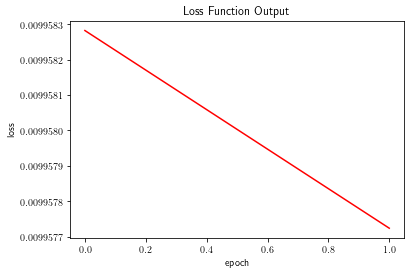

In [53]:

results_train_loss = his.history['loss']
plt.plot(results_train_loss, color='red')
plt.title('Loss Function Output')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

#### Plot Trained Model Ouput

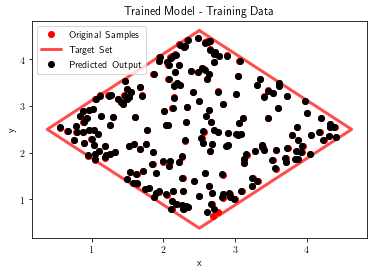

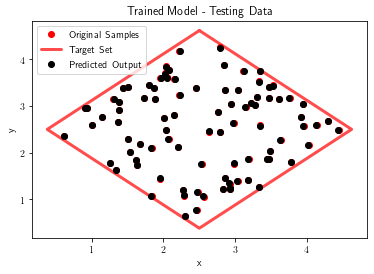

In [54]:
def plot_model(model, x_true, y_true, poly_1, poly_2, arg):
    y_predict = model_orig.predict(x_true)
    
    ## training output
    plt.plot(y_true[:, 0], y_true[:, 1], 'ro', label='Original Samples')
    x_poly_2, y_poly_2 = poly_2.exterior.xy
    plt.plot(x_poly_2, y_poly_2, color='red', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2,
             label='Target Set')

    ## predicted output
    plt.plot(y_predict[:, 0], y_predict[:, 1], 'ko', label='Predicted Output')
    plt.title(arg)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(loc="upper left")
    plt.show()
    return y_predict

y_predict_train = plot_model(model_orig, x_train, y_train, poly, poly2, arg='Trained Model - Training Data')
y_predict_test = plot_model(model_orig, x_test, y_test, poly, poly2, arg='Trained Model - Testing Data')

In [55]:
## save data
# import pickle 
# pickle.dump(x_train,open("x_train.dat","wb"))
# pickle.dump(y_predict_train,open("y_predict_train.dat","wb"))
# pickle.dump(y_train,open("y_train.dat","wb"))
# pickle.dump(w_0,open("w_0.dat","wb"))
# pickle.dump(b_0,open("b_0.dat","wb"))
# pickle.dump(w_1,open("w_1.dat","wb"))
# pickle.dump(b_1,open("b_1.dat","wb"))

#### Adversarial sample generator

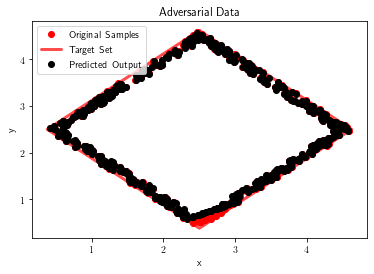

In [56]:
num_points_edge1 = 500
points_edge1 = random_points_edge(poly, num_points_edge1, scale = 0.9)
x_edge1 = np.ones((3, num_points_edge1))     #(x,y,b)

for i in range(num_points_edge1):
    x_edge1[0][i] = points_edge1[i].x
    x_edge1[1][i] = points_edge1[i].y

## rotate input points in-place by pi/4 radian
y_edge1 = np.matmul(np.matmul(np.matmul(transform1, rotate), transform2), x_edge1)
x_edge1 = np.transpose(x_edge1)
y_edge1 = np.transpose(y_edge1)

y_new = plot_model(model_orig, x_edge1, y_edge1, poly, poly2, arg='Adversarial Data')

In [57]:
for i in range(y_new.shape[0]):
    point = Point([y_new[i][0], y_new[i][1]])
    if not point.within(poly2):
        print("point: {} is out of bound".format(y_new[i]))

### Replicate the Original NN

#### Classes (NN with Numpy)

In [343]:
class Dense:
    def __init__(self, nin, nout):
        self.weights = np.random.rand(nin, nout) * 2 - 1
        self.bias = np.random.rand(nout) * 2 - 1
        
    def _relu(self, x):
        return np.maximum(x, 0)
    
    def __call__(self, x, relu=False):
        x = x @ self.weights + self.bias
        if relu:
            x = self._relu(x)
            
        return x

    def set_variables(self, weights=None, bias=None):
        if weights is not None:
            self.weights[:] = weights[:]
            
        if bias is not None:
            self.bias[:] = bias[:]
            
class MLP:
    def __init__(self, nin, uout, uhidden):
        self.num_layer = len(uhidden)+1
        prev = nin
        self.layers = []
        for u in uhidden:
            self.layers.append(Dense(prev, u))
            prev = u
        self.layers.append(Dense(prev, uout))
        
    def __call__(self, x, relu=False):
        
        if self.num_layer == 2:
            x1 = self.layers[0](x, relu=True)
            y = self.layers[1](x1, relu=relu)
            return x1, y
        
        if self.num_layer == 3:
            x1 = self.layers[0](x, relu=True)
            x2 = self.layers[1](x1, relu=True)
            y = self.layers[2](x2, relu=relu)
            return x1, x2, y

#### Reconstruct the Original NN to Obtain Diferrent Layer values given Input x0

In [344]:
b0_orig

array([-0.38489062,  0.        ,  0.24825697], dtype=float32)

In [345]:
tf.constant(b0_orig)

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-0.38489062,  0.        ,  0.24825697], dtype=float32)>

In [346]:
mlp_orig = MLP(num_input, num_output, [num_hidden_0, num_hidden_1])
mlp_orig.layers[0].weights=w0_orig   
mlp_orig.layers[1].weights=w1_orig  
mlp_orig.layers[2].weights=w2_orig  
mlp_orig.layers[0].bias=b0_orig
mlp_orig.layers[1].bias=b1_orig
mlp_orig.layers[2].bias=b2_orig

X0_orig_train, X1_orig_train, Y_orig_train = mlp_orig(x_train, relu=False)
X0_orig_test, X1_orig_test, Y_orig_test = mlp_orig(x_test, relu=False)
# print("w0= "+str(w_0))
# print("w1= "+str(w_1))
# print("b0= "+str(b_0))
# print("b1= "+str(b_1))
# print("x_train= "+str(x_train))
# print("hiddel_layer= "+str(h_copy))
# print("y_predicted= "+str(y_copy))
print(y_predict_train)
print(Y_orig_train)

[[2.5440192  3.8066804  1.0085171 ]
 [3.2406118  1.4632897  0.9918013 ]
 [2.1800566  0.9048504  0.9816389 ]
 [2.4832454  3.7215426  1.0074762 ]
 [2.6384072  3.6864853  1.0079552 ]
 [2.170261   4.1052814  1.0092114 ]
 [2.3847823  3.7485132  1.0072129 ]
 [2.2554045  1.9182628  0.9907649 ]
 [1.1896907  1.9003377  0.9852415 ]
 [1.1033651  2.0418448  0.9860279 ]
 [3.305943   1.39295    0.9915233 ]
 [3.0456743  3.6414757  1.0096184 ]
 [2.6677399  0.89898366 0.984045  ]
 [3.7262506  3.211391   1.009335  ]
 [3.9334714  2.1481292  1.0012023 ]
 [3.3952222  3.2021005  1.0075872 ]
 [2.606717   3.5818372  1.0068924 ]
 [2.8775542  2.1384604  0.9957995 ]
 [1.524344   2.1451955  0.9890406 ]
 [2.8878915  4.0779366  1.0125905 ]
 [0.9628651  2.9129221  0.9928381 ]
 [1.2575135  1.9693482  0.98617876]
 [2.2307532  3.4448867  1.0038165 ]
 [1.7380264  1.2252438  0.9821773 ]
 [0.7538885  2.268727   0.9862255 ]
 [2.7762442  4.075392   1.0120062 ]
 [2.1901903  3.4932268  1.0040294 ]
 [1.4092273  3.079592   0.99

## Repair the network with the modification of the last layer

Repairing last layer $\mathbf{W}_{new}^2 \mathbf{x}^2 + \mathbf{b}_{new}^2 = \mathbf{y}$:

\begin{align}
       & \min_{\mathbf{W}^2,\mathbf{b}^2}
       & & \frac{1}{2}\sum^{N}_{n=1}|| \mathbf{y}(\mathbf{x}^2_n,\mathbf{W}^2,\mathbf{b}^2)-\mathbf{t}_n||^2_2, \\
       & \text{s.t.} & &   \mathbf{W}_{new}^2 \mathbf{x}^2 + \mathbf{b}_{new}^2 = \mathbf{y},\\
       & & & \mathbf{A}\mathbf{y}\leq b.
\end{align}

![repair_last_layer.jpg](repair_last_layer.jpg)

### Build 1 Layer MIP NN

#### classes

In [347]:
class MIPLayer:
    def __init__(self, model, uin, uout, w_orig, b_orig, param_bounds=(-1, 1)):
        model.nlayers = getattr(model, 'nlayers', 0)
        self.uin, self.uout = uin, uout
        
        w_l, b_l = 'w' + str(model.nlayers), 'b' + str(model.nlayers)
        
        setattr(model, w_l, pyo.Var(range(uin), range(uout), domain=pyo.Reals, bounds=param_bounds))
        setattr(model, b_l, pyo.Var(range(uout), domain=pyo.Reals, bounds=param_bounds))
        
        self.w = getattr(model, w_l)
        self.b = getattr(model, b_l)
        self.w_orig = w_orig
        self.b_orig = b_orig
        
        model.nlayers += 1
        self.model = model
        
    def __call__(self, x, shape, relu=False, output_bounds=(-1e1, 1e1)):
        self.model.lout = getattr(self.model, 'lout', 0) + 1
#         print(self.model.nlayers)
        if relu:
            return self._relu_constraints(x, shape, self.model.lout, output_bounds)
        return self._constraints(x, shape, self.model.lout, output_bounds)
    
    def _relu_constraints(self, x, shape, l, output_bounds=(-1e1, 1e1)):
        m, n = shape
        assert n == self.uin
        
        x_l, s_l, theta_l = 'x'+str(l), 's'+str(l), 'theta'+str(l)
        
        setattr(self.model, x_l, pyo.Var(range(m), range(self.uout), domain=pyo.NonNegativeReals, bounds=output_bounds))
        setattr(self.model, s_l, pyo.Var(range(m), range(self.uout), domain=pyo.NonNegativeReals, bounds=output_bounds))
        setattr(self.model, theta_l, pyo.Var(range(m), range(self.uout), domain=pyo.Binary))
        
        def constraints(model, i, j):
            product = self.b[j]
            for k in range(self.uin):
                product += x[i, k] * self.w[k, j]
            return product == getattr(model, x_l)[i, j] - getattr(model, s_l)[i, j]
        
        setattr(self.model, 'eq_constraint'+str(l),
                pyo.Constraint(range(m), range(self.uout), rule=constraints))
        
        def disjuncts(model, i, j):
            return [(getattr(model, theta_l)[i, j] == 0, getattr(model, x_l)[i, j] <= 0),
                    (getattr(model, theta_l)[i, j] == 1, getattr(model, s_l)[i, j] <= 0)]
        
        setattr(self.model, 'disjunction'+str(l), pyg.Disjunction(range(m), range(self.uout), rule=disjuncts))
        return  getattr(self.model, x_l)
        
    def _constraints(self, x, shape, l, output_bounds=(-1e1, 1e1), w_b_bound_error = 1):
        m, n = shape
        assert n == self.uin
        w_l = 'w'+str(l-1)
        b_l = 'b'+str(l-1)
        x_l = 'x'+str(l)
        setattr(self.model, x_l, pyo.Var(range(m), range(self.uout), domain=pyo.Reals, bounds=output_bounds))
        
        def constraints(model, i, j):
            product = self.b[j]
            for k in range(self.uin):
                product += x[i, k] * self.w[k, j]
            return product == getattr(model, x_l)[i, j]

#         def constraint_inside0(model, i):
#              return(-getattr(model, x_l)[i, 0] + getattr(model, x_l)[i, 1] - 2.121 <= 0)
        
#         def constraint_inside1(model, i):
#              return(getattr(model, x_l)[i, 0] + getattr(model, x_l)[i, 1] - 7.129 <= 0)
        
#         def constraint_inside2(model, i):
#              return(getattr(model, x_l)[i, 0] - getattr(model, x_l)[i, 1] - 2.123 <= 0)
       
#         def constraint_inside3(model, i):
#              return(-getattr(model, x_l)[i, 0] - getattr(model, x_l)[i, 1] + 2.887 <= 0)
        def constraint_inside0(model, i):
             return(A[0,0]*getattr(model, x_l)[i, 0] + A[0,1]*getattr(model, x_l)[i, 1] - b[0] <= 0)
        
        def constraint_inside1(model, i):
             return(A[1,0]*getattr(model, x_l)[i, 0] + A[1,1]*getattr(model, x_l)[i, 1] - b[1] <= 0)
        
        def constraint_inside2(model, i):
             return(A[2,0]*getattr(model, x_l)[i, 0] + A[2,1]*getattr(model, x_l)[i, 1] - b[2] <= 0)
       
        def constraint_inside3(model, i):
             return(A[3,0]*getattr(model, x_l)[i, 0] + A[3,1]*getattr(model, x_l)[i, 1] - b[3] <= 0)
        
        #def constraint_bound_w0(model, i, j):
            #return(getattr(model, w_l)[i, j]-self.w_orig[i,j] <= w_b_bound_error)
        
        #def constraint_bound_w1(model, i, j): 
            #return(getattr(model, w_l)[i, j]-self.w_orig[i,j] >= -w_b_bound_error)
        
        #def constraint_bound_b0(model, j):
           # return(getattr(model, b_l)[j]-self.b_orig[j] <= w_b_bound_error)
        
        #def constraint_bound_b1(model, j): 
            #return(getattr(model, b_l)[j]-self.b_orig[j] >= -w_b_bound_error)
       
        setattr(self.model, 'eq_constraint'+str(l),
                pyo.Constraint(range(m), range(self.uout), rule=constraints))
        setattr(self.model, 'keep_inside_constraint0'+str(l),
                 pyo.Constraint(range(m), rule=constraint_inside0))
        setattr(self.model, 'keep_inside_constraint1'+str(l),
                 pyo.Constraint(range(m), rule=constraint_inside1))
        setattr(self.model, 'keep_inside_constraint2'+str(l),
                 pyo.Constraint(range(m), rule=constraint_inside2))
        setattr(self.model, 'keep_inside_constraint3'+str(l),
                 pyo.Constraint(range(m), rule=constraint_inside3))
        
        e_w_l = 'e_w'+str(l)
        setattr(self.model, e_w_l, pyo.Var(within=pyo.NonNegativeReals, bounds=(0,5), initialize=0.1))

        #e_b_l = 'e_b'+str(l)
        #setattr(self.model, e_b_l, pyo.Var(within=pyo.NonNegativeReals, bounds=(0,1), initialize=0.1))

        def constraint_w_bound_up(model, k, j):
            return(self.w[k, j] - self.w_orig[k, j] <= getattr(model, e_w_l))
        def constraint_w_bound_down(model, k, j):
            return(self.w[k, j] - self.w_orig[k, j] >= -getattr(model, e_w_l))
        def constraint_b_bound_up(model, j):
            return(self.b[j] - self.b_orig[j] <= getattr(model, e_w_l))
        def constraint_b_bound_down(model, j):
            return(self.b[j] - self.b_orig[j] >= -getattr(model, e_w_l))

        setattr(self.model, 'constraint_w_bound_up'+str(l),
                pyo.Constraint(range(self.uin), range(self.uout), rule=constraint_w_bound_up))
        setattr(self.model, 'constraint_w_bound_down'+str(l),
                pyo.Constraint(range(self.uin), range(self.uout), rule=constraint_w_bound_down))
        setattr(self.model, 'constraint_b_bound_up'+str(l),
                pyo.Constraint(range(self.uout), rule=constraint_b_bound_up))
        setattr(self.model, 'constraint_b_bound_down'+str(l),
                pyo.Constraint(range(self.uout), rule=constraint_b_bound_down))
        #setattr(self.model, 'w_bounded_constraint0'+str(l),
                #pyo.Constraint(range(self.uin), range(self.uout), rule=constraint_bound_w0))
        #setattr(self.model, 'w_bounded_constraint1'+str(l),
                #pyo.Constraint(range(self.uin), range(self.uout), rule=constraint_bound_w1))
        #setattr(self.model, 'b_bounded_constraint0'+str(l),
                #pyo.Constraint(range(self.uout), rule=constraint_bound_b0))
        #setattr(self.model, 'b_bounded_constraint1'+str(l),
                #pyo.Constraint(range(self.uout), rule=constraint_bound_b1))
        
        return getattr(self.model, x_l)

In [348]:
class MIPNNModel:
    def __init__(self, uin, uout, uhidden, w2_orig, b2_orig, param_bounds=(-1, 1)):
        self.model = pyo.ConcreteModel()
        
        self.model.nlayers = 0
        
        self.uin, self.uout = uin, uout
        
        self.layers = []
        prev = uin
        for u in uhidden:
            self.layers.append(MIPLayer(self.model, prev, u, w2_orig, b2_orig, param_bounds))
            prev = u
        self.layers.append(MIPLayer(self.model, prev, uout, w2_orig, b2_orig, param_bounds))
        
    def __call__(self, x, shape, relu=False, output_bounds=(-1e1, 1e1)):
        m, n = shape
        assert n == self.uin
        
        for layer in self.layers[:-1]:
            x = layer(x, (m, layer.uin), relu=True, output_bounds=output_bounds)
        
        layer = self.layers[-1]
        y = layer(x, (m, layer.uin), relu=relu, output_bounds=output_bounds)
        return y

#### Building 1 Layer

In [349]:

num_samples = X1_orig_train.shape[0]
mip_model_layer3 = MIPNNModel(num_hidden_1, num_output, [], w2_orig, b2_orig)
y_ = mip_model_layer3(X1_orig_train, (num_samples, num_hidden_1))
#print(y_train)

model_lay3 = mip_model_layer3.model
#pprint(vars(model_lay3))
#print(mip_model_layer3.model.eq_constraint1[(0,0)])





#### Final Output and Ojbective

In [350]:
def squared_sum(x, y, m, n):
    _squared_sum = 0
    for i in range(m):
        for j in range(n):
            _squared_sum += (x[i, j] - y[i, j]) ** 2
    return _squared_sum

cost_expr = squared_sum(y_, y_train, num_samples, num_output) ## check correctness

# regularization term for weigts
#for j in range(num_output):
#    cost_expr += regularizer_rate*model_lay3.b0[j]**2
#    for i in range(num_hidden_1):
#        cost_expr += regularizer_rate*model_lay3.w0[i, j]**2

cost_expr += model_lay3.e_w1**2

model_lay3.obj = pyo.Objective(expr=cost_expr)
pyo.TransformationFactory('gdp.bigm').apply_to(model_lay3)
opt = pyo.SolverFactory('gurobi',solver_io="python")

opt.solve(model_lay3, tee=True)

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter LogFile to C:\Users\kmajd1\AppData\Local\Temp\tmp4n9xs35t.log
   Prev:   Default: 
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 1494 rows, 643 columns and 4242 nonzeros
Model fingerprint: 0xa01a5b25
Model has 631 quadratic objective terms
Coefficient statistics:
  Matrix range     [7e-02, 4e+00]
  Objective range  [1e+00, 9e+00]
  QObjective range [2e+00, 2e+00]
  Bounds range     [1e+00, 1e+01]
  RHS range        [3e-03, 5e+00]
Presolve removed 426 rows and 0 columns
Presolve time: 0.02s
Presolved: 1068 rows, 1029 columns, 3776 nonzeros
Presolved model has 631 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 9
 AA' NZ     : 3.150e+03
 Factor NZ  : 8.399e+03 (roughly 1 MByte of memory)
 Factor Ops : 7.404e+04 (less than 1 second per iteration)
 Thre

{'Problem': [{'Name': 'unknown', 'Lower bound': 24.138901460801662, 'Upper bound': 24.138901460801662, 'Number of objectives': 1, 'Number of constraints': 1494, 'Number of variables': 643, 'Number of binary variables': 0, 'Number of integer variables': 0, 'Number of continuous variables': 643, 'Number of nonzeros': 4242, 'Sense': 1, 'Number of solutions': 1}], 'Solver': [{'Name': 'Gurobi 9.10', 'Status': 'ok', 'Wallclock time': 0.07299232482910156, 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.'}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [351]:
# #print the model in to a file (can also be saved in an lp format model_lay3.write(XXX.lp))

# original_stdout = sys.stdout # Save a reference to the original standard output

# with open('last_layer_mip_model_w_bounded.txt', 'w') as f:
#     sys.stdout = f # Change the standard output to the file we created.
#     model_lay3.pprint()
#     sys.stdout = original_stdout # Reset the standard output to its original value

In [352]:
model_lay3.e_w1.display()

e_w1 : Size=1, Index=None
    Key  : Lower : Value              : Upper : Fixed : Stale : Domain
    None :     0 : 0.7605881185332238 :     5 : False : False : NonNegativeReals


In [353]:
model_lay3.w0.display()

w0 : Size=9, Index=w0_index
    Key    : Lower : Value                 : Upper : Fixed : Stale : Domain
    (0, 0) :    -1 :   -0.5000531172253739 :     1 : False : False :  Reals
    (0, 1) :    -1 :    0.5901236151055027 :     1 : False : False :  Reals
    (0, 2) :    -1 : 3.580841319528183e-05 :     1 : False : False :  Reals
    (1, 0) :    -1 :  -0.12551577877721432 :     1 : False : False :  Reals
    (1, 1) :    -1 :   -0.2063105787281947 :     1 : False : False :  Reals
    (1, 2) :    -1 :   0.16067177547793166 :     1 : False : False :  Reals
    (2, 0) :    -1 :    0.9246469571088476 :     1 : False : False :  Reals
    (2, 1) :    -1 :    0.3369863373251045 :     1 : False : False :  Reals
    (2, 2) :    -1 : 8.776713487401722e-05 :     1 : False : False :  Reals


In [354]:
model_lay3.b0.display()

b0 : Size=3, Index=b0_index
    Key : Lower : Value              : Upper : Fixed : Stale : Domain
      0 :    -1 : 0.9999999999971405 :     1 : False : False :  Reals
      1 :    -1 : 0.7470694608745669 :     1 : False : False :  Reals
      2 :    -1 : 0.9997009157810783 :     1 : False : False :  Reals


In [355]:
print(w2_orig) #previously trained nn weights
print(b2_orig) #previously trained nn bias

[[-0.70399517  0.79542744  0.00331858]
 [-0.22533692 -0.3705961   0.28851905]
 [ 0.9938741   0.5087391   0.00939754]]
[ 1.1584313  -0.01351866  0.9685662 ]


In [356]:
model_lay3.x1.display()

x1 : Size=630, Index=x1_index
    Key      : Lower : Value              : Upper : Fixed : Stale : Domain
      (0, 0) : -10.0 : 2.7060272160477954 :  10.0 : False : False :  Reals
      (0, 1) : -10.0 :  3.447759835045863 :  10.0 : False : False :  Reals
      (0, 2) : -10.0 :  1.000086992482597 :  10.0 : False : False :  Reals
      (1, 0) : -10.0 :  2.992232737273989 :  10.0 : False : False :  Reals
      (1, 1) : -10.0 : 1.7477868575210884 :  10.0 : False : False :  Reals
      (1, 2) : -10.0 : 0.9999196294034469 :  10.0 : False : False :  Reals
      (2, 0) : -10.0 : 2.0034628953403075 :  10.0 : False : False :  Reals
      (2, 1) : -10.0 : 1.3770275187672247 :  10.0 : False : False :  Reals
      (2, 2) : -10.0 : 0.9998246540887905 :  10.0 : False : False :  Reals
      (3, 0) : -10.0 : 2.6422451902262853 :  10.0 : False : False :  Reals
      (3, 1) : -10.0 : 3.3884089249432296 :  10.0 : False : False :  Reals
      (3, 2) : -10.0 : 1.0000770455653374 :  10.0 : False : False :  R

In [357]:
print(Y_orig_train)

[[2.54401925 3.80668016 1.00851711]
 [3.24061182 1.4632898  0.9918013 ]
 [2.18005681 0.9048504  0.9816389 ]
 [2.48324545 3.72154244 1.00747616]
 [2.63840749 3.68648478 1.00795524]
 [2.17026091 4.10528143 1.00921137]
 [2.38478234 3.74851337 1.00721292]
 [2.25540444 1.91826284 0.99076489]
 [1.18969077 1.90033783 0.98524149]
 [1.10336502 2.04184497 0.98602791]
 [3.30594295 1.39295021 0.99152334]
 [3.04567427 3.64147567 1.00961845]
 [2.66773995 0.89898362 0.98404504]
 [3.7262506  3.21139094 1.00933504]
 [3.93347175 2.1481291  1.0012023 ]
 [3.39522229 3.20210089 1.00758726]
 [2.60671747 3.58183702 1.00689242]
 [2.87755419 2.13846007 0.99579951]
 [1.52434406 2.14519538 0.98904064]
 [2.88789174 4.0779369  1.01259055]
 [0.96286511 2.91292195 0.99283809]
 [1.2575133  1.96934822 0.98617876]
 [2.23075317 3.44488625 1.00381647]
 [1.7380262  1.22524375 0.98217731]
 [0.75388846 2.26872686 0.98622551]
 [2.77624499 4.07539158 1.01200614]
 [2.19018986 3.49322663 1.00402933]
 [1.40922745 3.07959219 0.99

In [358]:
y_new = np.zeros((num_samples, num_hidden_1))
w2_new = np.zeros((num_hidden_1, num_output))
b2_new = np.zeros((1, num_output))
for i in range(num_samples):
    for j in range(num_hidden_1):
        y_new[i, j] = model_lay3.x1[i, j].value
for j in range(num_output):
    b2_new[0, j] = model_lay3.b0[j].value
    for i in range(num_hidden_1):
        w2_new[i, j] = model_lay3.w0[i, j].value
print(w2_new)
print(b2_new)


[[-5.00053117e-01  5.90123615e-01  3.58084132e-05]
 [-1.25515779e-01 -2.06310579e-01  1.60671775e-01]
 [ 9.24646957e-01  3.36986337e-01  8.77671349e-05]]
[[1.         0.74706946 0.99970092]]


#### Build Refined NN 

In [359]:
mlp_lay3 = MLP(num_input, num_output, [num_hidden_0, num_hidden_1])
mlp_lay3.layers[0].weights=w0_orig   
mlp_lay3.layers[1].weights=w1_orig  
mlp_lay3.layers[2].weights=w2_new  
mlp_lay3.layers[0].bias=b0_orig
mlp_lay3.layers[1].bias=b1_orig
mlp_lay3.layers[2].bias=b2_new

_, _, y_new_train = mlp_lay3(x_train, relu=False)
_, _, y_new_test = mlp_lay3(x_test, relu=False)

#### Plot New Results

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


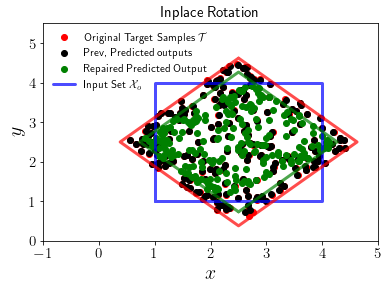

In [360]:
# ## training input
# plt.plot(x_train[:, 0], x_train[:, 1], 'bo', label='Input Sample')
# x_poly, y_poly = poly.exterior.xy
# plt.plot(x_poly, y_poly, color='blue', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

## predicted output (training)
x_poly_2, y_poly_2 = poly2.exterior.xy
plt.plot(y_train[:, 0], y_train[:, 1], 'ro', label='Original Target Samples $\mathcal{T}$')
plt.plot(y_predict_train[:, 0], y_predict_train[:, 1], 'ko', label='Prev, Predicted outputs')
plt.plot(y_new_train[:, 0], y_new_train[:, 1], 'go', label='Repaired Predicted Output')
plt.plot(x_poly, y_poly, color='blue', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Input Set $\mathcal{X}_o$')
plt.plot(x_poly_2, y_poly_2, color='red', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2 )
plt.plot(x_poly3, y_poly3, color='green', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)
plt.xlim([-1,5])
plt.ylim([0,5.5])
plt.title(r'Inplace Rotation',fontsize=15)
plt.xlabel('$x$',fontsize=20)
plt.ylabel('$y$',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc="upper left",frameon=False,fontsize=11)
plt.savefig('paper_data/affine_rotate/last_layer.eps', format='eps')
plt.show()

# ## testing input
# plt.plot(x_test[:, 0], x_test[:, 1], 'bo', label='Input Sample')
# x_poly, y_poly = poly.exterior.xy
# plt.plot(x_poly, y_poly, color='blue', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

## predicted output (testing)
# x_poly_2, y_poly_2 = poly2.exterior.xy
# plt.plot(y_test[:, 0], y_test[:, 1], 'ro', label='Original Samples')
# plt.plot(y_predict_test[:, 0], y_predict_test[:, 1], 'ko', label='Prev Predicted outputs')
# plt.plot(x_poly_2, y_poly_2, color='red', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Target Set')
# plt.plot(x_poly3, y_poly3, color='green', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Target Set')
# plt.plot(y_new_test[:, 0], y_new_test[:, 1], 'go', label='New Predicted Output')
# plt.title('Refined Model (Testing Data)')
# plt.xlabel('x')
# plt.ylabel('y')
# plt.legend(loc="upper left")
# plt.show()

In [361]:
MSE_original_nn_train = squared_sum(y_train, y_predict_train, num_samples, 2)/y_train.shape[0]
MSE_new_nn_train = squared_sum(y_train, y_new_train, num_samples, 2)/y_train.shape[0]
MSE_original_nn_test = squared_sum(y_test, y_predict_test, y_test.shape[0], 2)/y_test.shape[0]
MSE_new_nn_test = squared_sum(Y_orig_test, y_new_test, y_test.shape[0], 2)/y_test.shape[0]

from IPython.display import HTML, display
import tabulate
table = [["MSE","Training Data"," Testing Data"],
         ["Original NN",round(MSE_original_nn_train,5),round(MSE_original_nn_test,5)],
         ["Repaired NN (Last Layer)",round(MSE_new_nn_train,5),round(MSE_new_nn_test,5)]]
display(HTML(tabulate.tabulate(table, tablefmt='html')))

weight_error = np.linalg.norm(w2_new-w2_orig)
bias_error = np.linalg.norm(b2_new-b2_orig)
print("weight_error: {}".format(weight_error))
print("bias_error: {}".format(bias_error))

MSE,Training Data,Testing Data
Original NN,0.00015,4e-05
Repaired NN (Last Layer),0.11219,0.09062


weight_error: 0.414040823547114
bias_error: 0.7775372221548184


## Repair the network with the modification of the second layer

In the second layer:
$$
\mathbf{W}^1 \mathbf{X}^1 + \mathbf{b}^1 = \mathbf{H}^1,
$$
$$
\mathbf{X}^2 = \mathrm{ReLU} (\mathbf{H}^1),
$$
optimizing:

\begin{align}
       & \min_{\mathbf{W}^1,\mathbf{b}^1}
       & & \frac{1}{2}\sum^{N}_{n=1}|| \mathbf{y}(\mathbf{x}^1_n,\mathbf{W}^1,\mathbf{b}^1)-\mathbf{t}_n||^2_2, \\
       & \text{s.t.} & &   \mathbf{W}^2 \mathbf{x}^2 + \mathbf{b}^2 = \mathbf{y},\\
       & & & \mathbf{A}\mathbf{y}\leq b,\\
       & & & \sum_j w_{ij}^1 x_{jn}^1 + b_i^1 = x_{in}^2 - s_{in}^2, &&&&n=1,\cdots,N,~i=1,\cdots,c,~\mbox{and }j=1,\cdots,q,\\
       & & & x_{in}^2, s_{in}^2 \ge 0, &&&&n=1,\cdots,N,~\mbox{and }i=1,\cdots,c,\\
       & & & \theta_{in}^2 \in \{0, 1\}, &&&&n=1,\cdots,N,~\mbox{and }i=1,\cdots,c,\\
       & & & \theta_{in}^2=0 \rightarrow x_{in}^2 \le 0, &&&&n=1,\cdots,N,~\mbox{and }i=1,\cdots,c,\\
       & & & \theta_{in}^2=1 \rightarrow s_{in}^2 \le 0, &&&&n=1,\cdots,N,~\mbox{and }i=1,\cdots,c,
\end{align}
, where $N$, $c$, and $q$ are the number of samples, the number of hidden nodes, and the number of inputs, respectively.   

![repair_second_layer.jpg](repair_second_layer.jpg)

### Replicate the Original NN

#### Classes (NN with Numpy)

In [362]:
class MIPLayer1:
    def __init__(self, model, uin, uout, w1_orig, b1_orig, w2_orig, b2_orig, last_layer, param_bounds=(-1, 1)):
        model.nlayers = getattr(model, 'nlayers', 0)
        self.uin, self.uout = uin, uout
        if last_layer == False:
            w_l, b_l = 'w' + str(model.nlayers), 'b' + str(model.nlayers)
        
            setattr(model, w_l, pyo.Var(range(uin), range(uout), domain=pyo.Reals, bounds=param_bounds))
            setattr(model, b_l, pyo.Var(range(uout), domain=pyo.Reals, bounds=param_bounds))
        
            self.w = getattr(model, w_l)
            self.b = getattr(model, b_l)
            self.w_orig = w1_orig
            self.b_orig = b1_orig
        else:
            self.w = w2_orig
            self.b = b2_orig
        model.nlayers += 1
        self.model = model
        
    def __call__(self, x, shape, relu=False, output_bounds=(-1e1, 1e1)):
        self.model.lout = getattr(self.model, 'lout', 0) + 1
#         print(self.model.nlayers)
        if relu:
            return self._relu_constraints(x, shape, self.model.lout, output_bounds)
        return self._constraints(x, shape, self.model.lout, output_bounds)
    
    def _relu_constraints(self, x, shape, l, output_bounds=(-1e1, 1e1), w_b_bound_error = 1):
        m, n = shape
        assert n == self.uin
        
        x_l, s_l, theta_l = 'x'+str(l), 's'+str(l), 'theta'+str(l)
        w_l = 'w' + str(l-1)
        b_l = 'b' + str(l-1)
        setattr(self.model, x_l, pyo.Var(range(m), range(self.uout), domain=pyo.NonNegativeReals, bounds=output_bounds))
        setattr(self.model, s_l, pyo.Var(range(m), range(self.uout), domain=pyo.NonNegativeReals, bounds=output_bounds))
        setattr(self.model, theta_l, pyo.Var(range(m), range(self.uout), domain=pyo.Binary))
        
        def constraints(model, i, j):
            product = self.b[j]
            for k in range(self.uin):
                product += x[i, k] * self.w[k, j]
            return product == getattr(model, x_l)[i, j] - getattr(model, s_l)[i, j]
        
        setattr(self.model, 'eq_constraint'+str(l),
                pyo.Constraint(range(m), range(self.uout), rule=constraints))
        
        if l==1:
            e_w_l = 'e_w'+str(l)
            setattr(self.model, e_w_l, pyo.Var(within=pyo.NonNegativeReals, bounds=(0,5), initialize=0.1))

            #e_b_l = 'e_b'+str(l)
            #setattr(self.model, e_b_l, pyo.Var(within=pyo.NonNegativeReals, bounds=(0,1), initialize=0.1))

            def constraint_w_bound_up(model, k, j):
                return(self.w[k, j] - self.w_orig[k, j] <= getattr(model, e_w_l))
            def constraint_w_bound_down(model, k, j):
                return(self.w[k, j] - self.w_orig[k, j] >= -getattr(model, e_w_l))
            def constraint_b_bound_up(model, j):
                return(self.b[j] - self.b_orig[j] <= getattr(model, e_w_l))
            def constraint_b_bound_down(model, j):
                return(self.b[j] - self.b_orig[j] >= -getattr(model, e_w_l))

            setattr(self.model, 'constraint_w_bound_up'+str(l),
                    pyo.Constraint(range(self.uin), range(self.uout), rule=constraint_w_bound_up))
            setattr(self.model, 'constraint_w_bound_down'+str(l),
                    pyo.Constraint(range(self.uin), range(self.uout), rule=constraint_w_bound_down))
            setattr(self.model, 'constraint_b_bound_up'+str(l),
                    pyo.Constraint(range(self.uout), rule=constraint_b_bound_up))
            setattr(self.model, 'constraint_b_bound_down'+str(l),
                    pyo.Constraint(range(self.uout), rule=constraint_b_bound_down))
#             def constraint_bound_w0(model, i, j):
#                 return(getattr(model, w_l)[i, j]-self.w_orig[i,j] <= w_b_bound_error)
        
#             def constraint_bound_w1(model, i, j): 
#                 return(getattr(model, w_l)[i, j]-self.w_orig[i,j] >= -w_b_bound_error)
        
#             def constraint_bound_b0(model, j):
#                 return(getattr(model, b_l)[j]-self.b_orig[j] <= w_b_bound_error)
        
#             def constraint_bound_b1(model, j): 
#                 return(getattr(model, b_l)[j]-self.b_orig[j] >= -w_b_bound_error)
            
#             setattr(self.model, 'w_bounded_constraint0'+str(l),
#                 pyo.Constraint(range(self.uin), range(self.uout), rule=constraint_bound_w0))
#             setattr(self.model, 'w_bounded_constraint1'+str(l),
#                 pyo.Constraint(range(self.uin), range(self.uout), rule=constraint_bound_w1))
#             setattr(self.model, 'b_bounded_constraint0'+str(l),
#                 pyo.Constraint(range(self.uout), rule=constraint_bound_b0))
#             setattr(self.model, 'b_bounded_constraint1'+str(l),
#                 pyo.Constraint(range(self.uout), rule=constraint_bound_b1))
            
        
        def disjuncts(model, i, j):
            return [(getattr(model, theta_l)[i, j] == 0, getattr(model, x_l)[i, j] <= 0),
                    (getattr(model, theta_l)[i, j] == 1, getattr(model, s_l)[i, j] <= 0)]
        
        setattr(self.model, 'disjunction'+str(l), pyg.Disjunction(range(m), range(self.uout), rule=disjuncts))
        return  getattr(self.model, x_l)
        
    def _constraints(self, x, shape, l, output_bounds=(-1e1, 1e1)):
        m, n = shape
        assert n == self.uin
        
        x_l = 'x'+str(l)
        setattr(self.model, x_l, pyo.Var(range(m), range(self.uout), domain=pyo.Reals, bounds=output_bounds))
        
        def constraints(model, i, j):
            product = self.b[j]
            for k in range(self.uin):
                product += x[i, k] * self.w[k, j]
            return product == getattr(model, x_l)[i, j]

#         def constraint_inside0(model, i):
#              return(-getattr(model, x_l)[i, 0] + getattr(model, x_l)[i, 1] - 2.121 <= 0)
        
#         def constraint_inside1(model, i):
#              return(getattr(model, x_l)[i, 0] + getattr(model, x_l)[i, 1] - 7.129 <= 0)
        
#         def constraint_inside2(model, i):
#              return(getattr(model, x_l)[i, 0] - getattr(model, x_l)[i, 1] - 2.123 <= 0)
       
#         def constraint_inside3(model, i):
#              return(-getattr(model, x_l)[i, 0] - getattr(model, x_l)[i, 1] + 2.887 <= 0)

        def constraint_inside0(model, i):
             return(np.round(A[0,0],4)*getattr(model, x_l)[i, 0] + np.round(A[0,1],4)*getattr(model, x_l)[i, 1] - b[0] <= 0)
        
        def constraint_inside1(model, i):
             return(np.round(A[1,0],4)*getattr(model, x_l)[i, 0] + np.round(A[1,1],4)*getattr(model, x_l)[i, 1] - b[1] <= 0)
        
        def constraint_inside2(model, i):
             return(np.round(A[2,0],4)*getattr(model, x_l)[i, 0] + np.round(A[2,1],4)*getattr(model, x_l)[i, 1] - b[2] <= 0)
       
        def constraint_inside3(model, i):
             return(np.round(A[3,0],4)*getattr(model, x_l)[i, 0] + np.round(A[3,1],4)*getattr(model, x_l)[i, 1] - b[3] <= 0)
       
        setattr(self.model, 'eq_constraint'+str(l),
                pyo.Constraint(range(m), range(self.uout), rule=constraints))
        setattr(self.model, 'keep_inside_constraint0'+str(l),
                 pyo.Constraint(range(m), rule=constraint_inside0))
        setattr(self.model, 'keep_inside_constraint1'+str(l),
                 pyo.Constraint(range(m), rule=constraint_inside1))
        setattr(self.model, 'keep_inside_constraint2'+str(l),
                 pyo.Constraint(range(m), rule=constraint_inside2))
        setattr(self.model, 'keep_inside_constraint3'+str(l),
                 pyo.Constraint(range(m), rule=constraint_inside3))
        
        return getattr(self.model, x_l)

In [363]:
class MIPNNModel1:
    def __init__(self, uin, uout, uhidden, w1_orig, b1_orig, w2_orig, b2_orig, param_bounds=(-1, 1)):
        self.model = pyo.ConcreteModel()
        
        self.model.nlayers = 0
        
        self.uin, self.uout = uin, uout
        
        self.layers = []
        prev = uin
        for u in uhidden:
            self.layers.append(MIPLayer1(self.model, prev, u, w1_orig, b1_orig, w2_orig, b2_orig, False, param_bounds))
            prev = u
        self.layers.append(MIPLayer1(self.model, prev, uout, w1_orig, b1_orig, w2_orig, b2_orig, True, param_bounds))
        
    def __call__(self, x, shape, relu=False, output_bounds=(-1e1, 1e1)):
        m, n = shape
        assert n == self.uin
        
        for layer in self.layers[:-1]:
            x = layer(x, (m, layer.uin), relu=True, output_bounds=output_bounds)
        
        layer = self.layers[-1]
        y = layer(x, (m, layer.uin), relu=relu, output_bounds=output_bounds)
        return y

In [191]:
import copy
w2_temp = copy.deepcopy(w2_orig) 
b2_temp = copy.deepcopy(b2_orig) 

In [192]:
b2_temp

array([ 1.1584313 , -0.01351866,  0.9685662 ], dtype=float32)

In [193]:
for i in range(w2_temp.shape[0]):
    b2_temp[i] = b2_new[0][i]
    for j in range(w2_temp.shape[1]):
        w2_temp[i,j] = w2_new[i,j]

In [194]:
w2_temp = np.array(w2_new,dtype=np.float32)

In [195]:
w2_temp

array([[-5.0005311e-01,  5.9012359e-01,  3.5808414e-05],
       [-1.2551577e-01, -2.0631059e-01,  1.6067177e-01],
       [ 9.2464697e-01,  3.3698633e-01,  8.7767134e-05]], dtype=float32)

#### Building the middle layer with the fixed weights for the final layer

In [364]:
num_samples = X0_orig_train.shape[0]
mip_model_layer2 = MIPNNModel1(num_hidden_0, num_output, [num_hidden_1], w1_orig, b1_orig, w2_orig, b2_orig)
y_ = mip_model_layer2(np.round(X0_orig_train,4), (num_samples, num_hidden_0))


model_lay2 = mip_model_layer2.model
#pprint(vars(model_lay2))
#pprint(mip_model_layer2.model.eq_constraint1)
#print(y_)



#### Final Output and Ojbective

In [365]:
def squared_sum(x, y, m, n):
    _squared_sum = 0
    for i in range(m):
        for j in range(n):
            _squared_sum += (x[i, j] - y[i, j]) ** 2
    return _squared_sum

cost_expr = squared_sum(y_, y_train, num_samples, num_output) ## check correctness

# regularization term for weigts
# for j in range(num_hidden_1):
#     cost_expr += regularizer_rate*model_lay2.b0[j]**2
#     for i in range(num_hidden_0):
#         cost_expr += regularizer_rate*model_lay2.w0[i, j]**2
cost_expr += model_lay2.e_w1**2



model_lay2.obj = pyo.Objective(expr=cost_expr)
pyo.TransformationFactory('gdp.bigm').apply_to(model_lay2)
opt = pyo.SolverFactory('gurobi')
opt.options['timelimit'] = 1000
opt.options['mipgap'] = 0.01
opt.options['mipfocus'] = 2
opt.solve(model_lay2, tee=True)


Using license file C:\Users\kmajd1\gurobi.lic
Academic license - for non-commercial use only - expires 2022-08-25
Read LP format model from file C:\Users\kmajd1\AppData\Local\Temp\tmpbrjx8nbb.pyomo.lp
Reading time = 0.11 seconds
: 6535 rows, 3794 columns, 14959 nonzeros
Changed value of parameter timelimit to 1000.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter mipgap to 0.01
   Prev: 0.0001  Min: 0.0  Max: inf  Default: 0.0001
Changed value of parameter mipfocus to 2
   Prev: 0  Min: 0  Max: 3  Default: 0
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 6535 rows, 3794 columns and 14959 nonzeros
Model fingerprint: 0x1402b07a
Model has 631 quadratic objective terms
Variable types: 1904 continuous, 1890 integer (1890 binary)
Coefficient statistics:
  Matrix range     [3e-03, 1e+01]
  Objective range  [1e+00, 3e+03]
  QObjective range [2e+00, 2e+00]
  Boun

 179196 82883    9.06910   56   81    9.59193    8.50365  11.3%   4.1  155s
 188842 87548    8.59329   36   98    9.59193    8.50749  11.3%   4.1  160s
 197962 92619    8.77240   44   92    9.59193    8.51092  11.3%   4.1  166s
 208791 96293    8.70782   37   94    9.59193    8.51630  11.2%   4.1  170s
 216144 100200    8.98142   52   84    9.59193    8.51953  11.2%   4.1  175s
 225255 103275    9.06910   60   81    9.59193    8.53372  11.0%   4.0  180s
 233932 107704    8.61258   34   97    9.59193    8.53806  11.0%   4.0  186s
 241569 111812    9.46675   72   58    9.59193    8.53806  11.0%   4.0  190s
 248841 117803    9.18126   59   76    9.59193    8.53913  11.0%   4.0  195s
 258663 125407    8.91414   44   86    9.59193    8.54127  11.0%   4.0  200s
 268863 132716    8.91414   45   88    9.59193    8.54276  10.9%   4.0  205s
 277301 139961    9.03699   50   83    9.59193    8.54276  10.9%   4.0  211s
 284764 145753    9.52817   77   54    9.59193    8.54276  10.9%   4.0  216s
 29

 930243 694334    9.30849   64   70    9.59080    8.60219  10.3%   4.0  690s
 936537 700482    9.51201   75   55    9.59080    8.60219  10.3%   4.0  695s
 943476 706417    9.30212   63   69    9.59080    8.60219  10.3%   4.0  700s
 949489 712177    9.56858   80   51    9.59080    8.60219  10.3%   4.0  706s
 954742 716614    8.88562   45   88    9.59080    8.60401  10.3%   4.0  710s
 961750 721934    8.93888   46   86    9.59080    8.60543  10.3%   4.0  716s
 965921 726495    8.99165   48   84    9.59080    8.60543  10.3%   4.0  720s
 971505 730953    9.58350   81   50    9.59080    8.60757  10.3%   4.0  725s
 978010 736569    8.74030   39   93    9.59080    8.60757  10.3%   4.0  731s
 985013 741869    9.01722   49   82    9.59080    8.60957  10.2%   4.0  736s
 988374 745366    8.76882   39   93    9.59080    8.60957  10.2%   4.0  740s
 995132 750271     cutoff   87         9.59080    8.60957  10.2%   4.0  745s
 1002111 755125    9.10509   52   79    9.59080    8.60957  10.2%   4.0  750

{'Problem': [{'Name': '', 'Lower bound': 8.62147837458223, 'Upper bound': 9.590795584690564, 'Number of objectives': 1, 'Number of constraints': 6535, 'Number of variables': 3794, 'Number of binary variables': 1890, 'Number of integer variables': 1890, 'Number of continuous variables': 1904, 'Number of nonzeros': 14959, 'Sense': 'minimize'}], 'Solver': [{'Status': 'aborted', 'Return code': '0', 'Message': 'Optimization terminated because the time expended exceeded the value specified in the TimeLimit parameter.', 'Termination condition': 'maxTimeLimit', 'Termination message': 'Optimization terminated because the time expended exceeded the value specified in the TimeLimit parameter.', 'Wall time': '1000.3159580230713', 'Error rc': 0, 'Time': 1002.4063336849213}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [366]:
# #print the model in to a file (can also be saved in an lp format model_lay3.write(XXX.lp))

# original_stdout = sys.stdout # Save a reference to the original standard output

# with open('second_layer_mip_model_w_bounded.txt', 'w') as f:
#     sys.stdout = f # Change the standard output to the file we created.
#     model_lay2.pprint()
#     sys.stdout = original_stdout # Reset the standard output to its original value

In [367]:
model_lay2.e_w1.display()

e_w1 : Size=1, Index=None
    Key  : Lower : Value              : Upper : Fixed : Stale : Domain
    None :     0 : 0.4408146557681025 :     5 : False : False : NonNegativeReals


In [368]:
model_lay2.w0.display()

w0 : Size=9, Index=w0_index
    Key    : Lower : Value                : Upper : Fixed : Stale : Domain
    (0, 0) :    -1 :   0.8668692670374009 :     1 : False : False :  Reals
    (0, 1) :    -1 :  0.20737994884177594 :     1 : False : False :  Reals
    (0, 2) :    -1 :   0.2158765482853876 :     1 : False : False :  Reals
    (1, 0) :    -1 :   -0.217742457985878 :     1 : False : False :  Reals
    (1, 1) :    -1 :  0.08497969806194305 :     1 : False : False :  Reals
    (1, 2) :    -1 : -0.31831449270248413 :     1 : False : False :  Reals
    (2, 0) :    -1 : -0.21321327218719927 :     1 : False : False :  Reals
    (2, 1) :    -1 : -0.20046199795802722 :     1 : False : False :  Reals
    (2, 2) :    -1 :   0.8513447770593608 :     1 : False : False :  Reals


In [369]:
model_lay2.b0.display()

b0 : Size=3, Index=b0_index
    Key : Lower : Value                 : Upper : Fixed : Stale : Domain
      0 :    -1 : -0.038786269307767865 :     1 : False : False :  Reals
      1 :    -1 :   -0.3542795158425301 :     1 : False : False :  Reals
      2 :    -1 :    0.3776536853479983 :     1 : False : False :  Reals


In [370]:
print(w1_orig) #previously trained nn weights

[[ 1.0205908  -0.2334347   0.247066  ]
 [-0.23833324  0.10557048 -0.33890527]
 [-0.24518307 -0.13706161  1.0159961 ]]


In [371]:
model_lay2.x2.display()

x2 : Size=630, Index=x2_index
    Key      : Lower : Value              : Upper : Fixed : Stale : Domain
      (0, 0) : -10.0 : 2.5466029405746156 :  10.0 : False : False :  Reals
      (0, 1) : -10.0 : 3.6073494616518333 :  10.0 : False : False :  Reals
      (0, 2) : -10.0 : 1.0068097732609054 :  10.0 : False : False :  Reals
      (1, 0) : -10.0 : 3.1269705370074505 :  10.0 : False : False :  Reals
      (1, 1) : -10.0 : 1.6131624698656264 :  10.0 : False : False :  Reals
      (1, 2) : -10.0 : 0.9925223172314164 :  10.0 : False : False :  Reals
      (2, 0) : -10.0 : 2.2326497083685597 :  10.0 : False : False :  Reals
      (2, 1) : -10.0 : 1.1478829189819382 :  10.0 : False : False :  Reals
      (2, 2) : -10.0 : 0.9840013740661664 :  10.0 : False : False :  Reals
      (3, 0) : -10.0 :  2.495178155153611 :  10.0 : False : False :  Reals
      (3, 1) : -10.0 : 3.5355274172299187 :  10.0 : False : False :  Reals
      (3, 2) : -10.0 : 1.0059308417678818 :  10.0 : False : False :  R

In [372]:
print(Y_orig_train)

[[2.54401925 3.80668016 1.00851711]
 [3.24061182 1.4632898  0.9918013 ]
 [2.18005681 0.9048504  0.9816389 ]
 [2.48324545 3.72154244 1.00747616]
 [2.63840749 3.68648478 1.00795524]
 [2.17026091 4.10528143 1.00921137]
 [2.38478234 3.74851337 1.00721292]
 [2.25540444 1.91826284 0.99076489]
 [1.18969077 1.90033783 0.98524149]
 [1.10336502 2.04184497 0.98602791]
 [3.30594295 1.39295021 0.99152334]
 [3.04567427 3.64147567 1.00961845]
 [2.66773995 0.89898362 0.98404504]
 [3.7262506  3.21139094 1.00933504]
 [3.93347175 2.1481291  1.0012023 ]
 [3.39522229 3.20210089 1.00758726]
 [2.60671747 3.58183702 1.00689242]
 [2.87755419 2.13846007 0.99579951]
 [1.52434406 2.14519538 0.98904064]
 [2.88789174 4.0779369  1.01259055]
 [0.96286511 2.91292195 0.99283809]
 [1.2575133  1.96934822 0.98617876]
 [2.23075317 3.44488625 1.00381647]
 [1.7380262  1.22524375 0.98217731]
 [0.75388846 2.26872686 0.98622551]
 [2.77624499 4.07539158 1.01200614]
 [2.19018986 3.49322663 1.00402933]
 [1.40922745 3.07959219 0.99

In [373]:
X2_new = np.zeros((num_samples,num_output))
w1_new = np.zeros((num_hidden_0,num_hidden_1))
b1_new = np.zeros((1,num_hidden_1))
for i in range(num_samples):
    for j in range(num_output):
        X2_new[i, j] = model_lay2.x2[i, j].value
for j in range(num_hidden_1):
    b1_new[0, j] = model_lay2.b0[j].value
    for i in range(num_hidden_0):
        w1_new[i, j] = model_lay2.w0[i, j].value
print(w1_new)
print(b1_new)

[[ 0.86686927  0.20737995  0.21587655]
 [-0.21774246  0.0849797  -0.31831449]
 [-0.21321327 -0.200462    0.85134478]]
[[-0.03878627 -0.35427952  0.37765369]]


#### Build Refined NN


In [374]:
mlp_lay2 = MLP(num_input, num_output, [num_hidden_0, num_hidden_1])
mlp_lay2.layers[0].weights=w0_orig   
mlp_lay2.layers[1].weights=w1_new  
mlp_lay2.layers[2].weights=w2_orig 
mlp_lay2.layers[0].bias=b0_orig
mlp_lay2.layers[1].bias=b1_new
mlp_lay2.layers[2].bias=b2_orig

_, _, y_new2_train = mlp_lay2(x_train, relu=False)
_, _, y_new2_test = mlp_lay2(x_test, relu=False)


#### Plot New Results


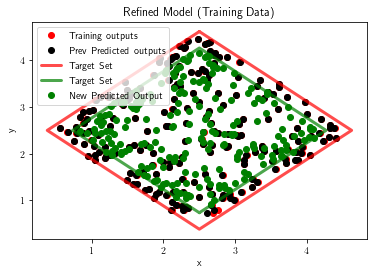

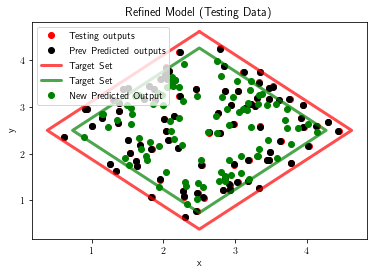

In [375]:
# ## training input
# plt.plot(x_train[:, 0], x_train[:, 1], 'bo', label='Input Sample')
# x_poly, y_poly = poly.exterior.xy
# plt.plot(x_poly, y_poly, color='blue', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

## predicted output (training)
x_poly_2, y_poly_2 = poly2.exterior.xy
plt.plot(y_train[:, 0], Y_orig_train[:, 1], 'ro', label='Training outputs')
plt.plot(y_predict_train[:, 0], y_predict_train[:, 1], 'ko', label='Prev Predicted outputs')
plt.plot(x_poly_2, y_poly_2, color='red', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Target Set')
plt.plot(x_poly3, y_poly3, color='green', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Target Set')
plt.plot(y_new2_train[:, 0], y_new2_train[:, 1], 'go', label='New Predicted Output')
plt.title('Refined Model (Training Data)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc="upper left")
plt.show()

# ## testing input
# plt.plot(x_test[:, 0], x_test[:, 1], 'bo', label='Input Sample')
# x_poly, y_poly = poly.exterior.xy
# plt.plot(x_poly, y_poly, color='blue', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

## predicted output (testing)
x_poly_2, y_poly_2 = poly2.exterior.xy
plt.plot(y_test[:, 0], y_test[:, 1], 'ro', label='Testing outputs')
plt.plot(y_predict_test[:, 0], y_predict_test[:, 1], 'ko', label='Prev Predicted outputs')
plt.plot(x_poly_2, y_poly_2, color='red', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Target Set')
plt.plot(x_poly3, y_poly3, color='green', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Target Set')
plt.plot(y_new2_test[:, 0], y_new2_test[:, 1], 'go', label='New Predicted Output')
plt.title('Refined Model (Testing Data)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc="upper left")
plt.show()

In [377]:
MSE_original_nn_train = squared_sum(y_train, y_predict_train, num_samples, 2)/y_train.shape[0]
MSE_new_nn_train = squared_sum(y_train, y_new2_train, num_samples, 2)/y_train.shape[0]
MSE_original_nn_test = squared_sum(y_test, y_predict_test, y_test.shape[0], 2)/y_test.shape[0]
MSE_new_nn_test = squared_sum(y_test, y_new2_test, y_test.shape[0], 2)/y_test.shape[0]

from IPython.display import HTML, display
import tabulate
table = [["MSE","Training Data"," Testing Data"],
         ["Original NN",round(MSE_original_nn_train,5),round(MSE_original_nn_test,5)],
         ["Modified NN",round(MSE_new_nn_train,5),round(MSE_new_nn_test,5)]]
display(HTML(tabulate.tabulate(table, tablefmt='html')))

weight_error = np.linalg.norm(w1_new-w1_orig)
bias_error = np.linalg.norm(b1_new-b1_orig)
print("weight_error: {}".format(weight_error))
print("bias_error: {}".format(bias_error))

MSE,Training Data,Testing Data
Original NN,0.00015,4e-05
Modified NN,0.04462,0.03869


weight_error: 0.5023388523643161
bias_error: 0.599541549808176


## Repair the network with the modification of the first layer

In the first layer:
$$
\mathbf{W}^0 \mathbf{X}^0 + \mathbf{b}^0 = \mathbf{H}^0,
$$
$$
\mathbf{X}^1 = \mathrm{ReLU} (\mathbf{H}^0),
$$
optimizing:

\begin{align}
       & \min_{\mathbf{W}^0,\mathbf{b}^0}
       & & \frac{1}{2}\sum^{N}_{n=1}|| \mathbf{y}(\mathbf{x}^0_n,\mathbf{W}^0,\mathbf{b}^0)-\mathbf{t}_n||^2_2, \\ \\
       & \text{s.t.} & &   \mathbf{W}^2 \mathbf{x}^2 + \mathbf{b}^2 = \mathbf{y},\\
       & & & \mathbf{A}\mathbf{y}\leq b,\\ \\
       & & & \sum_j w_{ij}^0 x_{jn}^0 + b_i^0 = x_{in}^1 - s_{in}^1, &&&&n=1,\cdots,N,~i=1,\cdots,c,~\mbox{and }j=1,\cdots,q,\\
       & & & x_{in}^1, s_{in}^1 \ge 0, &&&&n=1,\cdots,N,~\mbox{and }i=1,\cdots,c,\\
       & & & \theta_{in}^1 \in \{0, 1\}, &&&&n=1,\cdots,N,~\mbox{and }i=1,\cdots,c,\\
       & & & \theta_{in}^1=0 \rightarrow x_{in}^1 \le 0, &&&&n=1,\cdots,N,~\mbox{and }i=1,\cdots,c,\\
       & & & \theta_{in}^1=1 \rightarrow s_{in}^1 \le 0, &&&&n=1,\cdots,N,~\mbox{and }i=1,\cdots,c,\\ \\
       & & & \sum_j w_{ij}^1 x_{jn}^1 + b_i^1 = x_{in}^2 - s_{in}^2, &&&&n=1,\cdots,N,~i=1,\cdots,c,~\mbox{and }j=1,\cdots,q,\\
       & & & x_{in}^2, s_{in}^2 \ge 0, &&&&n=1,\cdots,N,~\mbox{and }i=1,\cdots,c,\\
       & & & \theta_{in}^2 \in \{0, 1\}, &&&&n=1,\cdots,N,~\mbox{and }i=1,\cdots,c,\\
       & & & \theta_{in}^2=0 \rightarrow x_{in}^2 \le 0, &&&&n=1,\cdots,N,~\mbox{and }i=1,\cdots,c,\\
       & & & \theta_{in}^2=1 \rightarrow s_{in}^2 \le 0, &&&&n=1,\cdots,N,~\mbox{and }i=1,\cdots,c,
\end{align}
, where $N$, $c$, and $q$ are the number of samples, the number of hidden nodes, and the number of inputs, respectively.   

![repair_first_layer.jpg](repair_first_layer.jpg)

### Replicate the Original NN

#### Classes (NN with Numpy)

In [253]:
class MIPLayer2:
    def __init__(self, model, uin, uout, w0_orig, b0_orig, w1_orig, b1_orig, w2_orig, b2_orig, param_bounds=(-1, 1)):
        model.nlayers = getattr(model, 'nlayers', 0)
        self.uin, self.uout = uin, uout
        if model.nlayers == 0:
            w_l, b_l = 'w' + str(model.nlayers), 'b' + str(model.nlayers)
        
            setattr(model, w_l, pyo.Var(range(uin), range(uout), domain=pyo.Reals, bounds=param_bounds))
            setattr(model, b_l, pyo.Var(range(uout), domain=pyo.Reals, bounds=param_bounds))
        
            self.w = getattr(model, w_l)
            self.b = getattr(model, b_l)
            self.w_orig = w0_orig
            self.b_orig = b0_orig
        elif model.nlayers == 1:
            self.w = w1_orig
            self.b = b1_orig
        elif model.nlayers == 2:
            self.w = w2_orig
            self.b = b2_orig
        model.nlayers += 1
        self.model = model
        
    def __call__(self, x, shape, relu=False, output_bounds=(-1e1, 1e1)):
        self.model.lout = getattr(self.model, 'lout', 0) + 1
#         print(self.model.nlayers)
        if relu:
            return self._relu_constraints(x, shape, self.model.lout, output_bounds)
        return self._constraints(x, shape, self.model.lout, output_bounds)
    
    def _relu_constraints(self, x, shape, l, output_bounds=(-1e1, 1e1), w_b_bound_error = 0.5):
        print(l)
        m, n = shape
        assert n == self.uin
        
        x_l, s_l, theta_l = 'x'+str(l), 's'+str(l), 'theta'+str(l)
        w_l = 'w'+str(l-1)
        b_l = 'b'+str(l-1)
        
        setattr(self.model, x_l, pyo.Var(range(m), range(self.uout), domain=pyo.NonNegativeReals, bounds=output_bounds))
        setattr(self.model, s_l, pyo.Var(range(m), range(self.uout), domain=pyo.NonNegativeReals, bounds=output_bounds))
        setattr(self.model, theta_l, pyo.Var(range(m), range(self.uout), domain=pyo.Binary))
        
        def constraints(model, i, j):
            product = self.b[j]
            for k in range(self.uin):
                product += x[i, k] * self.w[k, j]
            return product == getattr(model, x_l)[i, j] - getattr(model, s_l)[i, j]
        
        setattr(self.model, 'eq_constraint'+str(l),
                pyo.Constraint(range(m), range(self.uout), rule=constraints))
        
        if l==1:
            e_w_l = 'e_w'+str(l)
            setattr(self.model, e_w_l, pyo.Var(within=pyo.NonNegativeReals, bounds=(0,5), initialize=0.1))
            
            def constraint_w_bound_up(model, k, j):
                return(self.w[k, j] - self.w_orig[k, j] <= getattr(model, e_w_l))
            def constraint_w_bound_down(model, k, j):
                return(self.w[k, j] - self.w_orig[k, j] >= -getattr(model, e_w_l))
            def constraint_b_bound_up(model, j):
                return(self.b[j] - self.b_orig[j] <= getattr(model, e_w_l))
            def constraint_b_bound_down(model, j):
                return(self.b[j] - self.b_orig[j] >= -getattr(model, e_w_l))

            setattr(self.model, 'constraint_w_bound_up'+str(l),
                    pyo.Constraint(range(self.uin), range(self.uout), rule=constraint_w_bound_up))
            setattr(self.model, 'constraint_w_bound_down'+str(l),
                    pyo.Constraint(range(self.uin), range(self.uout), rule=constraint_w_bound_down))
            setattr(self.model, 'constraint_b_bound_up'+str(l),
                    pyo.Constraint(range(self.uout), rule=constraint_b_bound_up))
            setattr(self.model, 'constraint_b_bound_down'+str(l),
                    pyo.Constraint(range(self.uout), rule=constraint_b_bound_down))
#             def constraint_bound_w0(model, i, j):
#                 return(getattr(model, w_l)[i, j]-self.w_orig[i,j] <= w_b_bound_error)
        
#             def constraint_bound_w1(model, i, j): 
#                 return(getattr(model, w_l)[i, j]-self.w_orig[i,j] >= -w_b_bound_error)
        
#             def constraint_bound_b0(model, j):
#                 return(getattr(model, b_l)[j]-self.b_orig[j] <= w_b_bound_error)
        
#             def constraint_bound_b1(model, j): 
#                 return(getattr(model, b_l)[j]-self.b_orig[j] >= -w_b_bound_error)
            
#             setattr(self.model, 'w_bounded_constraint0'+str(l),
#                 pyo.Constraint(range(self.uin), range(self.uout), rule=constraint_bound_w0))
#             setattr(self.model, 'w_bounded_constraint1'+str(l),
#                 pyo.Constraint(range(self.uin), range(self.uout), rule=constraint_bound_w1))
#             setattr(self.model, 'b_bounded_constraint0'+str(l),
#                 pyo.Constraint(range(self.uout), rule=constraint_bound_b0))
#             setattr(self.model, 'b_bounded_constraint1'+str(l),
#                 pyo.Constraint(range(self.uout), rule=constraint_bound_b1))
            
        
        def disjuncts(model, i, j):
            return [(getattr(model, theta_l)[i, j] == 0, getattr(model, x_l)[i, j] <= 0),
                    (getattr(model, theta_l)[i, j] == 1, getattr(model, s_l)[i, j] <= 0)]
        
        setattr(self.model, 'disjunction'+str(l), pyg.Disjunction(range(m), range(self.uout), rule=disjuncts))
        return  getattr(self.model, x_l)
        
    def _constraints(self, x, shape, l, output_bounds=(-1e1, 1e1)):
        m, n = shape
        assert n == self.uin
        
        x_l = 'x'+str(l)
        setattr(self.model, x_l, pyo.Var(range(m), range(self.uout), domain=pyo.Reals, bounds=output_bounds))
        
        def constraints(model, i, j):
            product = self.b[j]
            for k in range(self.uin):
                product += x[i, k] * self.w[k, j]
            return product == getattr(model, x_l)[i, j]

#         def constraint_inside0(model, i):
#              return(-getattr(model, x_l)[i, 0] + getattr(model, x_l)[i, 1] - 2.121 <= 0)
        
#         def constraint_inside1(model, i):
#              return(getattr(model, x_l)[i, 0] + getattr(model, x_l)[i, 1] - 7.129 <= 0)
        
#         def constraint_inside2(model, i):
#              return(getattr(model, x_l)[i, 0] - getattr(model, x_l)[i, 1] - 2.123 <= 0)
       
#         def constraint_inside3(model, i):
#              return(-getattr(model, x_l)[i, 0] - getattr(model, x_l)[i, 1] + 2.887 <= 0)

        def constraint_inside0(model, i):
             return(np.round(A[0,0],4)*getattr(model, x_l)[i, 0] + np.round(A[0,1],4)*getattr(model, x_l)[i, 1] - np.round(b[0],4) <= 0)
        
        def constraint_inside1(model, i):
             return(np.round(A[1,0],4)*getattr(model, x_l)[i, 0] + np.round(A[1,1],4)*getattr(model, x_l)[i, 1] - np.round(b[1],4) <= 0)
        
        def constraint_inside2(model, i):
             return(np.round(A[2,0],4)*getattr(model, x_l)[i, 0] + np.round(A[2,1],4)*getattr(model, x_l)[i, 1] - np.round(b[2],4) <= 0)
       
        def constraint_inside3(model, i):
             return(np.round(A[3,0],4)*getattr(model, x_l)[i, 0] + np.round(A[3,1],4)*getattr(model, x_l)[i, 1] - np.round(b[3],4) <= 0)
       
        setattr(self.model, 'eq_constraint'+str(l),
                pyo.Constraint(range(m), range(self.uout), rule=constraints))
        setattr(self.model, 'keep_inside_constraint0'+str(l),
                 pyo.Constraint(range(m), rule=constraint_inside0))
        setattr(self.model, 'keep_inside_constraint1'+str(l),
                 pyo.Constraint(range(m), rule=constraint_inside1))
        setattr(self.model, 'keep_inside_constraint2'+str(l),
                 pyo.Constraint(range(m), rule=constraint_inside2))
        setattr(self.model, 'keep_inside_constraint3'+str(l),
                 pyo.Constraint(range(m), rule=constraint_inside3))
        
        return getattr(self.model, x_l)

In [254]:
class MIPNNModel2:
    def __init__(self, uin, uout, uhidden, w0_orig, b0_orig, w1_orig, b1_orig, w2_orig, b2_orig, param_bounds=(-1, 1)):
        self.model = pyo.ConcreteModel()
        
        self.model.nlayers = 0
        
        self.uin, self.uout = uin, uout
        
        self.layers = []
        prev = uin
        for u in uhidden:
            self.layers.append(MIPLayer2(self.model, prev, u, w0_orig, b0_orig, w1_orig, b1_orig, w2_orig, b2_orig, param_bounds))
            prev = u
        self.layers.append(MIPLayer2(self.model, prev, uout, w0_orig, b0_orig, w1_orig, b1_orig, w2_orig, b2_orig, param_bounds))
        
    def __call__(self, x, shape, relu=False, output_bounds=(-1e1, 1e1)):
        m, n = shape
        assert n == self.uin
        
        for layer in self.layers[:-1]:
            x = layer(x, (m, layer.uin), relu=True, output_bounds=output_bounds)
        
        layer = self.layers[-1]
        y = layer(x, (m, layer.uin), relu=relu, output_bounds=output_bounds)
        return y

#### Building the middle layer with the fixed weights for the final layer

In [220]:
w1_temp = copy.deepcopy(w1_orig) 
b1_temp = copy.deepcopy(b1_orig) 

In [221]:
b1_temp

array([-0.33252642,  0.        , -0.00660251], dtype=float32)

In [222]:
for i in range(w1_temp.shape[0]):
    b1_temp[i] = b1_new[0][i]
    for j in range(w1_temp.shape[1]):
        w1_temp[i,j] = w1_new[i,j]

In [257]:
num_samples = x_train.shape[0]
mip_model_layer1 = MIPNNModel2(num_input, num_output, [num_hidden_0, num_hidden_1],w0_orig,b0_orig, w1_orig, b1_orig, w2_orig, b2_orig)
y_ = mip_model_layer1(x_train, (num_samples, num_input))


model_lay1 = mip_model_layer1.model
#pprint(vars(model_lay1))
#print(mip_model_layer3.model.eq_constraint1[(0,0)])
#print(y_)

1
2


#### Final Output and Ojbective

In [258]:
def squared_sum(x, y, m, n):
    _squared_sum = 0
    for i in range(m):
        for j in range(n):
            _squared_sum += (x[i, j] - y[i, j]) ** 2
    return _squared_sum

cost_expr = squared_sum(y_, y_train, num_samples, num_output) ## check correctness

# regularization term for weigts
# for j in range(num_hidden_0):
#     cost_expr += regularizer_rate*model_lay1.b0[j]**2
#     for i in range(num_input):
#         cost_expr += regularizer_rate*model_lay1.w0[i, j]**2

cost_expr += model_lay1.e_w1**2

model_lay1.obj = pyo.Objective(expr=cost_expr)
pyo.TransformationFactory('gdp.bigm').apply_to(model_lay1)
opt = pyo.SolverFactory('gurobi')
opt.options['timelimit'] = 1000
opt.options['mipgap'] = 0.01
opt.options['mipfocus'] = 2
opt.solve(model_lay1, tee=True)

Using license file C:\Users\kmajd1\gurobi.lic
Academic license - for non-commercial use only - expires 2022-08-25
Read LP format model from file C:\Users\kmajd1\AppData\Local\Temp\tmp13moqzgb.pyomo.lp
Reading time = 0.11 seconds
: 11575 rows, 6944 columns, 26299 nonzeros
Changed value of parameter timelimit to 1000.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter mipgap to 0.01
   Prev: 0.0001  Min: 0.0  Max: inf  Default: 0.0001
Changed value of parameter mipfocus to 2
   Prev: 0  Min: 0  Max: 3  Default: 0
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 11575 rows, 6944 columns and 26299 nonzeros
Model fingerprint: 0x5e9404bd
Model has 631 quadratic objective terms
Variable types: 3164 continuous, 3780 integer (3780 binary)
Coefficient statistics:
  Matrix range     [3e-03, 1e+01]
  Objective range  [1e+00, 3e+03]
  QObjective range [2e+00, 2e+00]
  Bo

 199189 92105    9.12825   59  106    9.50221    8.69657  8.48%   7.2  276s
 203037 94006    9.01814   56  110    9.50221    8.70203  8.42%   7.4  280s
 207253 95500    9.26788   63   99    9.50221    8.71050  8.33%   7.7  285s
 211442 98121    9.46246   87   79    9.50221    8.72492  8.18%   7.9  290s
 216030 99971    8.85969   36  126    9.50221    8.73142  8.11%   8.2  296s
H219260 96129                       9.4901539    8.73447  7.96%   8.3  298s
 219366 97660    9.27940   61   94    9.49015    8.73447  7.96%   8.3  300s
 224780 100072    8.82116   36  131    9.49015    8.74513  7.85%   8.6  306s
 228544 101320    9.11483   65  105    9.49015    8.75387  7.76%   8.7  310s
 233294 103665    8.87194   35  129    9.49015    8.75988  7.70%   8.9  315s
 237806 105261     cutoff   80         9.49015    8.76440  7.65%   9.1  320s
 243038 107375    9.04089   46  112    9.49015    8.77104  7.58%   9.4  325s
 248526 108331    9.22808   59   99    9.49015    8.77628  7.52%   9.6  330s
 25340

 629881 354979    9.00905   45  114    9.49015    8.86603  6.58%  14.5  821s
 632748 357911    9.07284   48  110    9.49015    8.86603  6.58%  14.5  826s
 635654 360638    9.10922   50  108    9.49015    8.86603  6.58%  14.5  830s
 638802 363588    9.16953   54  105    9.49015    8.86603  6.58%  14.5  835s
 642388 366264    9.24383   59  101    9.49015    8.86603  6.58%  14.5  840s
 647591 369880    9.30947   65   92    9.49015    8.86603  6.58%  14.6  846s
 650800 372501    9.38974   71   86    9.49015    8.86603  6.58%  14.6  850s
 653873 374978    9.41883   74   83    9.49015    8.86603  6.58%  14.6  855s
 658250 378842    9.47775   80   70    9.49015    8.86603  6.58%  14.6  862s
 661394 381553    9.24540   57  101    9.49015    8.86778  6.56%  14.6  866s
 664633 384063    9.45458   77   78    9.49015    8.86803  6.56%  14.6  871s
 667905 387245    9.41907   69   83    9.49015    8.86811  6.55%  14.6  876s
 671518 390163    9.23164   58  102    9.49015    8.86819  6.55%  14.6  881s

{'Problem': [{'Name': '', 'Lower bound': 8.877604071204075, 'Upper bound': 9.490153938773036, 'Number of objectives': 1, 'Number of constraints': 11575, 'Number of variables': 6944, 'Number of binary variables': 3780, 'Number of integer variables': 3780, 'Number of continuous variables': 3164, 'Number of nonzeros': 26299, 'Sense': 'minimize'}], 'Solver': [{'Status': 'aborted', 'Return code': '0', 'Message': 'Optimization terminated because the time expended exceeded the value specified in the TimeLimit parameter.', 'Termination condition': 'maxTimeLimit', 'Termination message': 'Optimization terminated because the time expended exceeded the value specified in the TimeLimit parameter.', 'Wall time': '1000.1984939575195', 'Error rc': 0, 'Time': 1001.589567899704}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [259]:
#print the model in to a file (can also be saved in an lp format model_lay3.write(XXX.lp))

# original_stdout = sys.stdout # Save a reference to the original standard output

# with open('first_layer_mip_model_w_bounded.txt', 'w') as f:
#     sys.stdout = f # Change the standard output to the file we created.
#     model_lay1.pprint()
#     sys.stdout = original_stdout # Reset the standard output to its original value

In [284]:
model_lay1.e_w1.display()

e_w1 : Size=1, Index=None
    Key  : Lower : Value             : Upper : Fixed : Stale : Domain
    None :     0 : 0.390941345936978 :     5 : False : False : NonNegativeReals


In [260]:
model_lay1.w0.display()

w0 : Size=9, Index=w0_index
    Key    : Lower : Value                : Upper : Fixed : Stale : Domain
    (0, 0) :    -1 :   0.3242904941669628 :     1 : False : False :  Reals
    (0, 1) :    -1 :  -0.2964523171617454 :     1 : False : False :  Reals
    (0, 2) :    -1 :   0.5969280231962304 :     1 : False : False :  Reals
    (1, 0) :    -1 :   0.7216392163664482 :     1 : False : False :  Reals
    (1, 1) :    -1 : 0.023076286689763637 :     1 : False : False :  Reals
    (1, 2) :    -1 : -0.20584398025338788 :     1 : False : False :  Reals
    (2, 0) :    -1 : -0.19319335197714557 :     1 : False : False :  Reals
    (2, 1) :    -1 :   0.6371723207304132 :     1 : False : False :  Reals
    (2, 2) :    -1 :    0.364772269592215 :     1 : False : False :  Reals


In [261]:
model_lay1.b0.display()

b0 : Size=3, Index=b0_index
    Key : Lower : Value                : Upper : Fixed : Stale : Domain
      0 :    -1 : 0.006050729996883969 :     1 : False : False :  Reals
      1 :    -1 :    0.390941345936978 :     1 : False : False :  Reals
      2 :    -1 :     0.63919831240865 :     1 : False : False :  Reals


In [262]:
print(w0_orig) #previously trained nn weights

[[ 0.47810486 -0.01489583  0.7903533 ]
 [ 0.83961886 -0.2524295  -0.25857612]
 [-0.5841347   0.24623097  0.29334435]]


In [263]:
model_lay1.x3.display()

x3 : Size=630, Index=x3_index
    Key      : Lower : Value              : Upper : Fixed : Stale : Domain
      (0, 0) : -10.0 :  2.569653272482881 :  10.0 : False : False :  Reals
      (0, 1) : -10.0 :  3.626850924155291 :  10.0 : False : False :  Reals
      (0, 2) : -10.0 : 1.0070942031920358 :  10.0 : False : False :  Reals
      (1, 0) : -10.0 : 3.1421679658955037 :  10.0 : False : False :  Reals
      (1, 1) : -10.0 : 1.6198893422351681 :  10.0 : False : False :  Reals
      (1, 2) : -10.0 : 0.9926569338805155 :  10.0 : False : False :  Reals
      (2, 0) : -10.0 :  2.243328900735022 :  10.0 : False : False :  Reals
      (2, 1) : -10.0 : 1.1393131475548879 :  10.0 : False : False :  Reals
      (2, 2) : -10.0 : 0.9839812093331634 :  10.0 : False : False :  Reals
      (3, 0) : -10.0 : 2.5177962387526933 :  10.0 : False : False :  Reals
      (3, 1) : -10.0 :  3.553773934243098 :  10.0 : False : False :  Reals
      (3, 2) : -10.0 : 1.0062022631791059 :  10.0 : False : False :  R

In [264]:
print(Y_orig_train)

[[2.54401925 3.80668016 1.00851711]
 [3.24061182 1.4632898  0.9918013 ]
 [2.18005681 0.9048504  0.9816389 ]
 [2.48324545 3.72154244 1.00747616]
 [2.63840749 3.68648478 1.00795524]
 [2.17026091 4.10528143 1.00921137]
 [2.38478234 3.74851337 1.00721292]
 [2.25540444 1.91826284 0.99076489]
 [1.18969077 1.90033783 0.98524149]
 [1.10336502 2.04184497 0.98602791]
 [3.30594295 1.39295021 0.99152334]
 [3.04567427 3.64147567 1.00961845]
 [2.66773995 0.89898362 0.98404504]
 [3.7262506  3.21139094 1.00933504]
 [3.93347175 2.1481291  1.0012023 ]
 [3.39522229 3.20210089 1.00758726]
 [2.60671747 3.58183702 1.00689242]
 [2.87755419 2.13846007 0.99579951]
 [1.52434406 2.14519538 0.98904064]
 [2.88789174 4.0779369  1.01259055]
 [0.96286511 2.91292195 0.99283809]
 [1.2575133  1.96934822 0.98617876]
 [2.23075317 3.44488625 1.00381647]
 [1.7380262  1.22524375 0.98217731]
 [0.75388846 2.26872686 0.98622551]
 [2.77624499 4.07539158 1.01200614]
 [2.19018986 3.49322663 1.00402933]
 [1.40922745 3.07959219 0.99

In [265]:
X3_new = np.zeros((num_samples,num_output))
w0_new = np.zeros((num_input,num_hidden_0))
b0_new = np.zeros((1,num_hidden_0))
for i in range(num_samples):
    for j in range(num_output):
        X3_new[i, j] = model_lay1.x3[i, j].value
for j in range(num_hidden_0):
    b0_new[0, j] = model_lay1.b0[j].value
    for i in range(num_input):
        w0_new[i, j] = model_lay1.w0[i, j].value
print(w0_new)
print(b0_new)

[[ 0.32429049 -0.29645232  0.59692802]
 [ 0.72163922  0.02307629 -0.20584398]
 [-0.19319335  0.63717232  0.36477227]]
[[0.00605073 0.39094135 0.63919831]]


#### Build Refined NN


In [313]:
mlp_lay1 = MLP(num_input, num_output, [num_hidden_0, num_hidden_1])
mlp_lay1.layers[0].weights=w0_new   
mlp_lay1.layers[1].weights=w1_orig  
mlp_lay1.layers[2].weights=w2_orig 
mlp_lay1.layers[0].bias=b0_new
mlp_lay1.layers[1].bias=b1_orig
mlp_lay1.layers[2].bias=b2_orig

_, _, y_new1_train = mlp_lay1(x_train, relu=False)
_, _, y_new1_test = mlp_lay1(x_test, relu=False)


#### Plot New Results


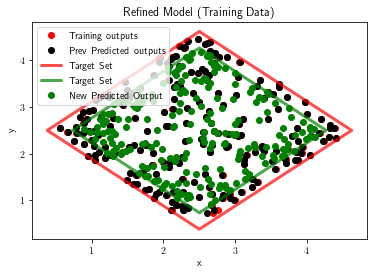

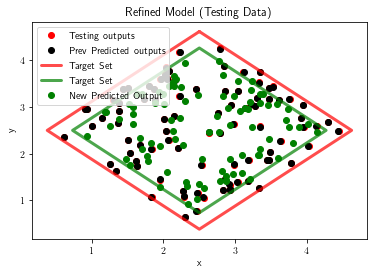

In [314]:
# ## training input
# plt.plot(x_train[:, 0], x_train[:, 1], 'bo', label='Input Sample')
# x_poly, y_poly = poly.exterior.xy
# plt.plot(x_poly, y_poly, color='blue', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

## predicted output (training)
x_poly_2, y_poly_2 = poly2.exterior.xy
plt.plot(y_train[:, 0], Y_orig_train[:, 1], 'ro', label='Training outputs')
plt.plot(y_predict_train[:, 0], y_predict_train[:, 1], 'ko', label='Prev Predicted outputs')
plt.plot(x_poly_2, y_poly_2, color='red', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Target Set')
plt.plot(x_poly3, y_poly3, color='green', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Target Set')
plt.plot(y_new1_train[:, 0], y_new1_train[:, 1], 'go', label='New Predicted Output')
plt.title('Refined Model (Training Data)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc="upper left")
plt.show()

# ## testing input
# plt.plot(x_test[:, 0], x_test[:, 1], 'bo', label='Input Sample')
# x_poly, y_poly = poly.exterior.xy
# plt.plot(x_poly, y_poly, color='blue', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

## predicted output (testing)
x_poly_2, y_poly_2 = poly2.exterior.xy
plt.plot(y_test[:, 0], y_test[:, 1], 'ro', label='Testing outputs')
plt.plot(y_predict_test[:, 0], y_predict_test[:, 1], 'ko', label='Prev Predicted outputs')
plt.plot(x_poly_2, y_poly_2, color='red', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Target Set')
plt.plot(x_poly3, y_poly3, color='green', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Target Set')
plt.plot(y_new1_test[:, 0], y_new1_test[:, 1], 'go', label='New Predicted Output')
plt.title('Refined Model (Testing Data)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc="upper left")
plt.show()

In [201]:
plt.rcParams['text.usetex'] = True

<ipython-input-204-2af16c959929>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


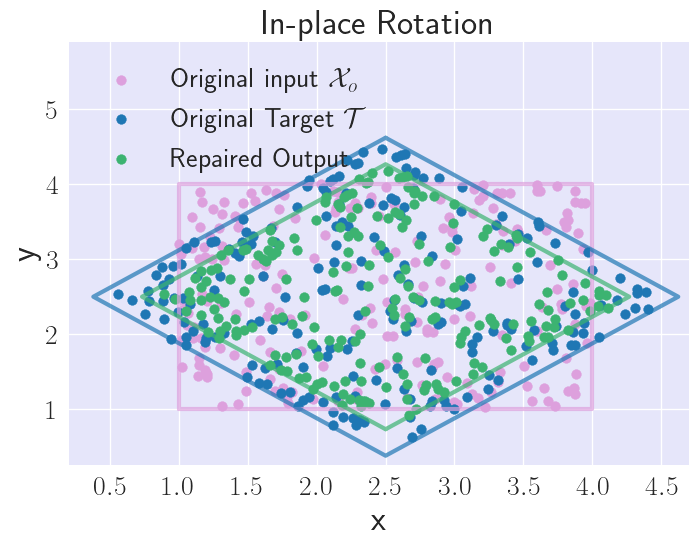

In [204]:
x_poly_2, y_poly_2 = poly2.exterior.xy
x_poly3, y_poly3 = poly3.exterior.xy
import matplotlib as mpl
mpl.style.use('seaborn')
plt.plot(x_poly, y_poly, color='plum', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)
plt.plot(x_poly_2, y_poly_2, color='tab:blue', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2 )
plt.plot(x_poly3, y_poly3, color='mediumseagreen', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)
plt.scatter(x_train[:, 0], x_train[:, 1], color='plum', label='Original input $\mathcal{X}_o$')
plt.scatter(y_train[:, 0], y_train[:, 1], color='tab:blue', label='Original Target $\mathcal{T}$')

plt.scatter(y_new1_train[:, 0], y_new1_train[:, 1], color='mediumseagreen', label='Repaired Output')


#plt.scatter(y_predict_train[:, 0], y_predict_train[:, 1], color='tab:red', label='Prev, Predicted outputs')

plt.xlim([0.2,4.7])
plt.ylim([0.25,5.9])
plt.title(r'In-place Rotation',fontsize=25)
plt.xlabel('x',fontsize=25)
plt.ylabel('y',fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.legend(loc="upper left",frameon=False,fontsize=20)
ax = plt.axes()
#ax.axis("off")
for pos in ['right', 'top','bottom','left']:
   plt.gca().spines[pos].set_visible(False)
ax.set_facecolor("lavender")
plt.savefig('paper_data/affine_rotate/last_layer.eps', format='eps')
plt.show()

In [ ]:
temp = Point([2.5, 0.72])
temp.within(poly3)

In [378]:
y_new_train
y_new2_train
y_new1_train

array([[2.56965327, 3.62685092, 1.0070942 ],
       [3.14216797, 1.61988934, 0.99265693],
       [2.2433289 , 1.13931315, 0.98398121],
       [2.51779624, 3.55377393, 1.00620226],
       [2.64852937, 3.52402182, 1.00660407],
       [2.25615115, 3.88204697, 1.0077174 ],
       [2.43486641, 3.57670251, 1.00598238],
       [2.31360417, 2.00794404, 0.99183209],
       [1.41397287, 1.99057607, 0.98715016],
       [1.34204233, 2.11168441, 0.98783305],
       [3.19684703, 1.55973169, 0.99241319],
       [2.99198536, 3.48621598, 1.00800799],
       [2.65491808, 1.13520347, 0.98601918],
       [3.55158573, 3.09321084, 1.00743517],
       [3.73148781, 2.20809734, 1.00070234],
       [3.28412513, 3.11033221, 1.00623557],
       [2.62109187, 3.43427959, 1.00569132],
       [2.8401793 , 2.19782315, 0.99612357],
       [1.69804979, 2.2010477 , 0.99039775],
       [2.85345532, 3.8423395 , 1.01038371],
       [1.229194  , 2.85792821, 0.99370513],
       [1.47167309, 2.04984529, 0.98795237],
       [2.

In [384]:
y_predict_train[0,:]

array([2.5440192, 3.8066804, 1.0085171], dtype=float32)

In [385]:
y_train[0,:]

array([2.54040736, 3.81309472, 1.        ])

In [13]:
row,col = y_train.shape

err_orig_out = 0.
err_1_out = 0.
err_2_out = 0.
err_3_out = 0.
err_orig_in = 0.
err_1_in = 0.
err_2_in = 0.
err_3_in = 0.


n_out = 0
n_in = 0


for i in range(row):
    temp = Point([y_train[i,0], y_train[i,1]])
    if not temp.within(poly3):
        err_orig_out = np.linalg.norm(y_predict_train[i,0:2]-y_train[i,0:2]) + err_orig_out
        err_1_out = np.linalg.norm(y_new1_train[i,0:2]-y_train[i,0:2]) + err_1_out
        err_2_out = np.linalg.norm(y_new2_train[i,0:2]-y_train[i,0:2]) + err_2_out
        err_3_out = np.linalg.norm(y_new_train[i,0:2]-y_train[i,0:2]) + err_3_out
        n_out += 1
    else:
        err_orig_in = np.linalg.norm(y_predict_train[i,0:2]-y_train[i,0:2]) + err_orig_in
        err_1_in = np.linalg.norm(y_new1_train[i,0:2]-y_train[i,0:2]) + err_1_in
        err_2_in = np.linalg.norm(y_new2_train[i,0:2]-y_train[i,0:2]) + err_2_in
        err_3_in = np.linalg.norm(y_new_train[i,0:2]-y_train[i,0:2]) + err_3_in
        n_in += 1
        


In [14]:
err_1_out/err_orig_out

26.59824008985162

In [15]:
err_orig_in = err_orig_in/n_in 
err_3_in = err_3_in/n_in
err_2_in = err_2_in/n_in
err_1_in = err_1_in/n_in

err_orig_out = err_orig_out/n_out
err_3_out = err_3_out/n_out
err_2_out = err_2_out/n_out
err_1_out = err_1_out/n_out

stats_orig = np.array([[err_orig_in, err_1_in, err_2_in, err_3_in],[err_orig_out, err_1_out, err_2_out, err_3_out]])
print(stats_orig)

[[0.0047277  0.15045611 0.15238239 0.22848521]
 [0.00934278 0.24850138 0.2491978  0.38254507]]


In [16]:
stats_orig[:,0]

array([0.0047277 , 0.00934278])

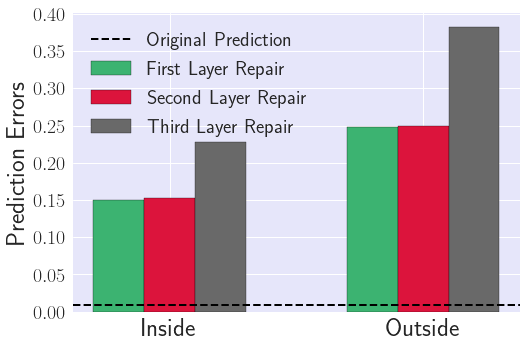

In [179]:
from matplotlib.pyplot import text
from matplotlib import pyplot as plt
labels = ['Inside', 'Outside']
x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars



fig, ax = plt.subplots()
#rects1 = ax.bar(x - 1.5*width, stats_orig[:,0], width, color='dodgerblue', label='Original Predictions',edgecolor = "black")
rects1 = ax.bar(x - width, stats_orig[:,1], width, color='mediumseagreen', label='First Layer Repair',edgecolor = "black")
rects2 = ax.bar(x , stats_orig[:,2], width, color='crimson', label='Second Layer Repair',edgecolor = "black")
rects2 = ax.bar(x + width, stats_orig[:,3], width, color='dimgray', label='Third Layer Repair',edgecolor = "black")
#ax.set_facecolor("black")
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Prediction Errors',fontsize=25)
#ax.set_title('Prediction Errors - ',fontsize=25)
ax.set_xticks(x)
ax.set_xticklabels(labels,fontsize=25)
plt.axhline(y=stats_orig[1,0],linewidth=2, color='k',linestyle ="--",label = 'Original Prediction')
ax.legend(loc="upper left",fontsize=20,frameon=False)

for pos in ['right', 'top','bottom','left']:
   plt.gca().spines[pos].set_visible(False)
ax.set_facecolor("lavender")
#plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig('paper_data/affine_rotate/states.eps', format='eps')

In [54]:
# import pickle

# with open('paper_data/affine_rotate/x_train.data', 'wb') as filehandle:
#     # store the data as binary data stream
#     pickle.dump(x_train, filehandle)
    
# with open('paper_data/affine_rotate/y_train.data', 'wb') as filehandle:
#     # store the data as binary data stream
#     pickle.dump(y_train, filehandle)
    
# with open('paper_data/affine_rotate/y_predict_repair_1.data', 'wb') as filehandle:
#     # store the data as binary data stream
#     pickle.dump(y_new1_train, filehandle)

# with open('paper_data/affine_rotate/y_predict_repair_2.data', 'wb') as filehandle:
#     # store the data as binary data stream
#     pickle.dump(y_new2_train, filehandle)
    
# with open('paper_data/affine_rotate/y_predict_repair_3_last.data', 'wb') as filehandle:
#     # store the data as binary data stream
#     pickle.dump(y_new_train, filehandle)
    
# with open('paper_data/affine_rotate/y_predict_original.data', 'wb') as filehandle:
#     # store the data as binary data stream
#     pickle.dump(y_predict_train, filehandle)

In [27]:
import pickle
import numpy as np
# with open('paper_data/affine_rotate/x_train.data', 'rb') as filehandle:
#     # read the data as binary data stream
#     x_train = pickle.load(filehandle)
with open('paper_data/affine_rotate/y_train.data', 'rb') as filehandle:
    # read the data as binary data stream
    y_train = pickle.load(filehandle)
with open('paper_data/affine_rotate/y_predict_repair_1.data', 'rb') as filehandle:
    # read the data as binary data stream
    y_new1_train = pickle.load(filehandle)
with open('paper_data/affine_rotate/y_predict_repair_2.data', 'rb') as filehandle:
    # read the data as binary data stream
    y_new2_train = pickle.load(filehandle)
with open('paper_data/affine_rotate/y_predict_repair_3_last.data', 'rb') as filehandle:
    # read the data as binary data stream
    y_new_train = pickle.load(filehandle)
with open('paper_data/affine_rotate/y_predict_original.data', 'rb') as filehandle:
    # read the data as binary data stream
    y_predict_train = pickle.load(filehandle)

EOFError: Ran out of input

In [316]:
MSE_original_nn_train = squared_sum(y_train, y_predict_train, num_samples, 2)/y_train.shape[0]
MSE_new_nn_train = squared_sum(y_train, y_new1_train, num_samples, 2)/y_train.shape[0]
MSE_original_nn_test = squared_sum(y_test, y_predict_test, y_test.shape[0], 2)/y_test.shape[0]
MSE_new_nn_test = squared_sum(y_test, y_new1_test, y_test.shape[0], 2)/y_test.shape[0]

from IPython.display import HTML, display
import tabulate
table = [["MSE","Training Data"," Testing Data"],
         ["Original NN",round(MSE_original_nn_train,5),round(MSE_original_nn_test,5)],
         ["Modified NN",round(MSE_new_nn_train,5),round(MSE_new_nn_test,5)]]
display(HTML(tabulate.tabulate(table, tablefmt='html')))

weight_error = np.linalg.norm(w0_new-w0_orig)
bias_error = np.linalg.norm(b0_new-b0_orig)
print("weight_error: {}".format(weight_error))
print("bias_error: {}".format(bias_error))
print(w0_new-w0_orig)

MSE,Training Data,Testing Data
Original NN,0.00015,4e-05
Modified NN,0.04439,0.03804


weight_error: 0.7373749242366117
bias_error: 0.6771302739422065
[[-0.15381437 -0.28155649 -0.19342527]
 [-0.11797965  0.27550577  0.05273214]
 [ 0.39094135  0.39094135  0.07142792]]


## Propagate it back

In [275]:
mlp_repair = MLP(num_input, num_output, [num_hidden_0, num_hidden_1])
mlp_repair.layers[0].weights=w0_new   
mlp_repair.layers[1].weights=w1_orig
mlp_repair.layers[2].weights=w2_orig  
mlp_repair.layers[0].bias=b0_new
mlp_repair.layers[1].bias=b1_orig
mlp_repair.layers[2].bias=b2_orig

X0_repair_train, X1_repair_train, Y_repair_train = mlp_orig(x_train, relu=False)
X0_repair_test, X1_repair_test, Y_repair_test = mlp_orig(x_test, relu=False)

### Second Layer Repair

In the second layer:
$$
\mathbf{W}^1 \mathbf{X}^1 + \mathbf{b}^1 = \mathbf{H}^1,
$$
$$
\mathbf{X}^2 = \mathrm{ReLU} (\mathbf{H}^1),
$$
optimizing:

\begin{align}
       & \min_{\mathbf{W}^1,\mathbf{b}^1}
       & & \frac{1}{2}\sum^{N}_{n=1}|| \mathbf{y}(\mathbf{x}^1_n,\mathbf{W}^1,\mathbf{b}^1)-\mathbf{t}_n||^2_2, \\
       & \text{s.t.} & &   \mathbf{W}^2 \mathbf{x}^2 + \mathbf{b}^2 = \mathbf{y},\\
       & & & \mathbf{A}\mathbf{y}\leq b,\\
       & & & \sum_j w_{ij}^1 x_{jn}^1 + b_i^1 = x_{in}^2 - s_{in}^2, &&&&n=1,\cdots,N,~i=1,\cdots,c,~\mbox{and }j=1,\cdots,q,\\
       & & & x_{in}^2, s_{in}^2 \ge 0, &&&&n=1,\cdots,N,~\mbox{and }i=1,\cdots,c,\\
       & & & \theta_{in}^2 \in \{0, 1\}, &&&&n=1,\cdots,N,~\mbox{and }i=1,\cdots,c,\\
       & & & \theta_{in}^2=0 \rightarrow x_{in}^2 \le 0, &&&&n=1,\cdots,N,~\mbox{and }i=1,\cdots,c,\\
       & & & \theta_{in}^2=1 \rightarrow s_{in}^2 \le 0, &&&&n=1,\cdots,N,~\mbox{and }i=1,\cdots,c,
\end{align}
, where $N$, $c$, and $q$ are the number of samples, the number of hidden nodes, and the number of inputs, respectively.   

![repair_second_layer.jpg](repair_second_layer.jpg)

### Replicate the Original NN

#### Classes (NN with Numpy)

In [276]:
class MIPLayer1:
    def __init__(self, model, uin, uout, w1_orig, b1_orig, w2_orig, b2_orig, last_layer, param_bounds=(-1, 1)):
        model.nlayers = getattr(model, 'nlayers', 0)
        self.uin, self.uout = uin, uout
        if last_layer == False:
            w_l, b_l = 'w' + str(model.nlayers), 'b' + str(model.nlayers)
        
            setattr(model, w_l, pyo.Var(range(uin), range(uout), domain=pyo.Reals, bounds=param_bounds))
            setattr(model, b_l, pyo.Var(range(uout), domain=pyo.Reals, bounds=param_bounds))
        
            self.w = getattr(model, w_l)
            self.b = getattr(model, b_l)
            self.w_orig = w1_orig
            self.b_orig = b1_orig
        else:
            self.w = w2_orig
            self.b = b2_orig
        model.nlayers += 1
        self.model = model
        
    def __call__(self, x, shape, relu=False, output_bounds=(-1e1, 1e1)):
        self.model.lout = getattr(self.model, 'lout', 0) + 1
#         print(self.model.nlayers)
        if relu:
            return self._relu_constraints(x, shape, self.model.lout, output_bounds)
        return self._constraints(x, shape, self.model.lout, output_bounds)
    
    def _relu_constraints(self, x, shape, l, output_bounds=(-1e1, 1e1), w_b_bound_error = 1):
        m, n = shape
        assert n == self.uin
        
        x_l, s_l, theta_l = 'x'+str(l), 's'+str(l), 'theta'+str(l)
        w_l = 'w' + str(l-1)
        b_l = 'b' + str(l-1)
        setattr(self.model, x_l, pyo.Var(range(m), range(self.uout), domain=pyo.NonNegativeReals, bounds=output_bounds))
        setattr(self.model, s_l, pyo.Var(range(m), range(self.uout), domain=pyo.NonNegativeReals, bounds=output_bounds))
        setattr(self.model, theta_l, pyo.Var(range(m), range(self.uout), domain=pyo.Binary))
        
        def constraints(model, i, j):
            product = self.b[j]
            for k in range(self.uin):
                product += x[i, k] * self.w[k, j]
            return product == getattr(model, x_l)[i, j] - getattr(model, s_l)[i, j]
        
        setattr(self.model, 'eq_constraint'+str(l),
                pyo.Constraint(range(m), range(self.uout), rule=constraints))
        
        if l==1:
            e_w_l = 'e_w'+str(l)
            setattr(self.model, e_w_l, pyo.Var(within=pyo.NonNegativeReals, bounds=(0,5), initialize=0.1))

            #e_b_l = 'e_b'+str(l)
            #setattr(self.model, e_b_l, pyo.Var(within=pyo.NonNegativeReals, bounds=(0,1), initialize=0.1))

            def constraint_w_bound_up(model, k, j):
                return(self.w[k, j] - self.w_orig[k, j] <= getattr(model, e_w_l))
            def constraint_w_bound_down(model, k, j):
                return(self.w[k, j] - self.w_orig[k, j] >= -getattr(model, e_w_l))
            def constraint_b_bound_up(model, j):
                return(self.b[j] - self.b_orig[j] <= getattr(model, e_w_l))
            def constraint_b_bound_down(model, j):
                return(self.b[j] - self.b_orig[j] >= -getattr(model, e_w_l))

            setattr(self.model, 'constraint_w_bound_up'+str(l),
                    pyo.Constraint(range(self.uin), range(self.uout), rule=constraint_w_bound_up))
            setattr(self.model, 'constraint_w_bound_down'+str(l),
                    pyo.Constraint(range(self.uin), range(self.uout), rule=constraint_w_bound_down))
            setattr(self.model, 'constraint_b_bound_up'+str(l),
                    pyo.Constraint(range(self.uout), rule=constraint_b_bound_up))
            setattr(self.model, 'constraint_b_bound_down'+str(l),
                    pyo.Constraint(range(self.uout), rule=constraint_b_bound_down))
#             def constraint_bound_w0(model, i, j):
#                 return(getattr(model, w_l)[i, j]-self.w_orig[i,j] <= w_b_bound_error)
        
#             def constraint_bound_w1(model, i, j): 
#                 return(getattr(model, w_l)[i, j]-self.w_orig[i,j] >= -w_b_bound_error)
        
#             def constraint_bound_b0(model, j):
#                 return(getattr(model, b_l)[j]-self.b_orig[j] <= w_b_bound_error)
        
#             def constraint_bound_b1(model, j): 
#                 return(getattr(model, b_l)[j]-self.b_orig[j] >= -w_b_bound_error)
            
#             setattr(self.model, 'w_bounded_constraint0'+str(l),
#                 pyo.Constraint(range(self.uin), range(self.uout), rule=constraint_bound_w0))
#             setattr(self.model, 'w_bounded_constraint1'+str(l),
#                 pyo.Constraint(range(self.uin), range(self.uout), rule=constraint_bound_w1))
#             setattr(self.model, 'b_bounded_constraint0'+str(l),
#                 pyo.Constraint(range(self.uout), rule=constraint_bound_b0))
#             setattr(self.model, 'b_bounded_constraint1'+str(l),
#                 pyo.Constraint(range(self.uout), rule=constraint_bound_b1))
            
        
        def disjuncts(model, i, j):
            return [(getattr(model, theta_l)[i, j] == 0, getattr(model, x_l)[i, j] <= 0),
                    (getattr(model, theta_l)[i, j] == 1, getattr(model, s_l)[i, j] <= 0)]
        
        setattr(self.model, 'disjunction'+str(l), pyg.Disjunction(range(m), range(self.uout), rule=disjuncts))
        return  getattr(self.model, x_l)
        
    def _constraints(self, x, shape, l, output_bounds=(-1e1, 1e1)):
        m, n = shape
        assert n == self.uin
        
        x_l = 'x'+str(l)
        setattr(self.model, x_l, pyo.Var(range(m), range(self.uout), domain=pyo.Reals, bounds=output_bounds))
        
        def constraints(model, i, j):
            product = self.b[j]
            for k in range(self.uin):
                product += x[i, k] * self.w[k, j]
            return product == getattr(model, x_l)[i, j]

#         def constraint_inside0(model, i):
#              return(-getattr(model, x_l)[i, 0] + getattr(model, x_l)[i, 1] - 2.121 <= 0)
        
#         def constraint_inside1(model, i):
#              return(getattr(model, x_l)[i, 0] + getattr(model, x_l)[i, 1] - 7.129 <= 0)
        
#         def constraint_inside2(model, i):
#              return(getattr(model, x_l)[i, 0] - getattr(model, x_l)[i, 1] - 2.123 <= 0)
       
#         def constraint_inside3(model, i):
#              return(-getattr(model, x_l)[i, 0] - getattr(model, x_l)[i, 1] + 2.887 <= 0)

        def constraint_inside0(model, i):
             return(np.round(A[0,0],4)*getattr(model, x_l)[i, 0] + np.round(A[0,1],4)*getattr(model, x_l)[i, 1] - b[0] <= 0)
        
        def constraint_inside1(model, i):
             return(np.round(A[1,0],4)*getattr(model, x_l)[i, 0] + np.round(A[1,1],4)*getattr(model, x_l)[i, 1] - b[1] <= 0)
        
        def constraint_inside2(model, i):
             return(np.round(A[2,0],4)*getattr(model, x_l)[i, 0] + np.round(A[2,1],4)*getattr(model, x_l)[i, 1] - b[2] <= 0)
       
        def constraint_inside3(model, i):
             return(np.round(A[3,0],4)*getattr(model, x_l)[i, 0] + np.round(A[3,1],4)*getattr(model, x_l)[i, 1] - b[3] <= 0)
       
        setattr(self.model, 'eq_constraint'+str(l),
                pyo.Constraint(range(m), range(self.uout), rule=constraints))
        setattr(self.model, 'keep_inside_constraint0'+str(l),
                 pyo.Constraint(range(m), rule=constraint_inside0))
        setattr(self.model, 'keep_inside_constraint1'+str(l),
                 pyo.Constraint(range(m), rule=constraint_inside1))
        setattr(self.model, 'keep_inside_constraint2'+str(l),
                 pyo.Constraint(range(m), rule=constraint_inside2))
        setattr(self.model, 'keep_inside_constraint3'+str(l),
                 pyo.Constraint(range(m), rule=constraint_inside3))
        
        return getattr(self.model, x_l)

In [277]:
class MIPNNModel1:
    def __init__(self, uin, uout, uhidden, w1_orig, b1_orig, w2_orig, b2_orig, param_bounds=(-1, 1)):
        self.model = pyo.ConcreteModel()
        
        self.model.nlayers = 0
        
        self.uin, self.uout = uin, uout
        
        self.layers = []
        prev = uin
        for u in uhidden:
            self.layers.append(MIPLayer1(self.model, prev, u, w1_orig, b1_orig, w2_orig, b2_orig, False, param_bounds))
            prev = u
        self.layers.append(MIPLayer1(self.model, prev, uout, w1_orig, b1_orig, w2_orig, b2_orig, True, param_bounds))
        
    def __call__(self, x, shape, relu=False, output_bounds=(-1e1, 1e1)):
        m, n = shape
        assert n == self.uin
        
        for layer in self.layers[:-1]:
            x = layer(x, (m, layer.uin), relu=True, output_bounds=output_bounds)
        
        layer = self.layers[-1]
        y = layer(x, (m, layer.uin), relu=relu, output_bounds=output_bounds)
        return y

#### Building the middle layer with the fixed weights for the final layer

In [278]:
num_samples = X0_repair_train.shape[0]
mip_model_layer2_rep = MIPNNModel1(num_hidden_0, num_output, [num_hidden_1], w1_orig, b1_orig, w2_orig, b2_orig)
y_ = mip_model_layer2_rep(np.round(X0_repair_train,4), (num_samples, num_hidden_0))


model_lay2_rep = mip_model_layer2_rep.model
#pprint(vars(model_lay2))
#pprint(mip_model_layer2.model.eq_constraint1)
#print(y_)



#### Final Output and Ojbective

In [279]:
def squared_sum(x, y, m, n):
    _squared_sum = 0
    for i in range(m):
        for j in range(n):
            _squared_sum += (x[i, j] - y[i, j]) ** 2
    return _squared_sum

cost_expr = squared_sum(y_, y_train, num_samples, num_output) ## check correctness

# regularization term for weigts
# for j in range(num_hidden_1):
#     cost_expr += regularizer_rate*model_lay2.b0[j]**2
#     for i in range(num_hidden_0):
#         cost_expr += regularizer_rate*model_lay2.w0[i, j]**2
cost_expr += model_lay2_rep.e_w1**2



model_lay2_rep.obj = pyo.Objective(expr=cost_expr)
pyo.TransformationFactory('gdp.bigm').apply_to(model_lay2_rep)
opt = pyo.SolverFactory('gurobi')
opt.options['timelimit'] = 1000
opt.options['mipgap'] = 0.01
opt.options['mipfocus'] = 2
opt.solve(model_lay2_rep, tee=True)


Using license file C:\Users\kmajd1\gurobi.lic
Academic license - for non-commercial use only - expires 2022-08-25
Read LP format model from file C:\Users\kmajd1\AppData\Local\Temp\tmpyzdoopcr.pyomo.lp
Reading time = 0.06 seconds
: 6535 rows, 3794 columns, 14959 nonzeros
Changed value of parameter timelimit to 1000.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter mipgap to 0.01
   Prev: 0.0001  Min: 0.0  Max: inf  Default: 0.0001
Changed value of parameter mipfocus to 2
   Prev: 0  Min: 0  Max: 3  Default: 0
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 6535 rows, 3794 columns and 14959 nonzeros
Model fingerprint: 0x1402b07a
Model has 631 quadratic objective terms
Variable types: 1904 continuous, 1890 integer (1890 binary)
Coefficient statistics:
  Matrix range     [3e-03, 1e+01]
  Objective range  [1e+00, 3e+03]
  QObjective range [2e+00, 2e+00]
  Boun

 177870 81972    8.82784   46   91    9.59193    8.50365  11.3%   4.1  166s
 184548 85752    9.48374   73   57    9.59193    8.50659  11.3%   4.1  170s
 192775 89270    8.93888   47   87    9.59193    8.51092  11.3%   4.1  175s
 202500 94367    9.41994   73   62    9.59193    8.51289  11.2%   4.1  181s
 211075 97915    9.16089   55   76    9.59193    8.51630  11.2%   4.1  185s
 218388 99969     cutoff   85         9.59193    8.52121  11.2%   4.0  190s
 226348 104107    9.30010   71   70    9.59193    8.53372  11.0%   4.0  195s
 233932 107704    8.61258   34   97    9.59193    8.53806  11.0%   4.0  201s
 241569 111812    9.46675   72   58    9.59193    8.53806  11.0%   4.0  205s
 248841 117803    9.18126   59   76    9.59193    8.53913  11.0%   4.0  210s
 256239 123771    9.36745   66   65    9.59193    8.54127  11.0%   4.0  215s
 266950 131489     cutoff   85         9.59193    8.54276  10.9%   4.0  220s
 275912 138332    8.74030   39   94    9.59193    8.54276  10.9%   4.0  225s
 2808

 889073 660698    9.23108   63   74    9.59080    8.60219  10.3%   4.0  705s
 895441 665640     cutoff   85         9.59080    8.60219  10.3%   4.0  711s
 902231 669884    8.70914   37   94    9.59080    8.60219  10.3%   4.0  715s
 907336 674817    9.55607   78   52    9.59080    8.60219  10.3%   4.0  721s
 912414 678657    9.41901   74   61    9.59080    8.60219  10.3%   4.0  725s
 919410 684668     cutoff   84         9.59080    8.60219  10.3%   4.0  730s
 924149 689709    9.58257   83   50    9.59080    8.60219  10.3%   4.0  735s
 932076 695715    8.88562   43   88    9.59080    8.60219  10.3%   4.0  740s
 936537 700482    9.51201   75   55    9.59080    8.60219  10.3%   4.0  745s
 943476 706417    9.30212   63   69    9.59080    8.60219  10.3%   4.0  750s
 949489 712177    9.56858   80   51    9.59080    8.60219  10.3%   4.0  755s
 956830 718117    8.70914   38   94    9.59080    8.60412  10.3%   4.0  760s
 963064 723637    9.19141   57   75    9.59080    8.60543  10.3%   4.0  766s

{'Problem': [{'Name': '', 'Lower bound': 8.621095165363064, 'Upper bound': 9.590795584690564, 'Number of objectives': 1, 'Number of constraints': 6535, 'Number of variables': 3794, 'Number of binary variables': 1890, 'Number of integer variables': 1890, 'Number of continuous variables': 1904, 'Number of nonzeros': 14959, 'Sense': 'minimize'}], 'Solver': [{'Status': 'aborted', 'Return code': '0', 'Message': 'Optimization terminated because the time expended exceeded the value specified in the TimeLimit parameter.', 'Termination condition': 'maxTimeLimit', 'Termination message': 'Optimization terminated because the time expended exceeded the value specified in the TimeLimit parameter.', 'Wall time': '1000.2277450561523', 'Error rc': 0, 'Time': 1002.1138060092926}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [280]:
# #print the model in to a file (can also be saved in an lp format model_lay3.write(XXX.lp))

# original_stdout = sys.stdout # Save a reference to the original standard output

# with open('second_layer_mip_model_w_bounded.txt', 'w') as f:
#     sys.stdout = f # Change the standard output to the file we created.
#     model_lay2.pprint()
#     sys.stdout = original_stdout # Reset the standard output to its original value

In [285]:
model_lay2_rep.e_w1.display()

e_w1 : Size=1, Index=None
    Key  : Lower : Value              : Upper : Fixed : Stale : Domain
    None :     0 : 0.4408146557681025 :     5 : False : False : NonNegativeReals


In [286]:
model_lay2_rep.w0.display()

w0 : Size=9, Index=w0_index
    Key    : Lower : Value                : Upper : Fixed : Stale : Domain
    (0, 0) :    -1 :   0.8668692670374009 :     1 : False : False :  Reals
    (0, 1) :    -1 :  0.20737994884177594 :     1 : False : False :  Reals
    (0, 2) :    -1 :   0.2158765482853876 :     1 : False : False :  Reals
    (1, 0) :    -1 :   -0.217742457985878 :     1 : False : False :  Reals
    (1, 1) :    -1 :  0.08497969806194305 :     1 : False : False :  Reals
    (1, 2) :    -1 : -0.31831449270248413 :     1 : False : False :  Reals
    (2, 0) :    -1 : -0.21321327218719927 :     1 : False : False :  Reals
    (2, 1) :    -1 : -0.20046199795802722 :     1 : False : False :  Reals
    (2, 2) :    -1 :   0.8513447770593608 :     1 : False : False :  Reals


In [287]:
model_lay2_rep.b0.display()

b0 : Size=3, Index=b0_index
    Key : Lower : Value                 : Upper : Fixed : Stale : Domain
      0 :    -1 : -0.038786269307767865 :     1 : False : False :  Reals
      1 :    -1 :   -0.3542795158425301 :     1 : False : False :  Reals
      2 :    -1 :    0.3776536853479983 :     1 : False : False :  Reals


In [288]:
model_lay2_rep.x2.display()

x2 : Size=630, Index=x2_index
    Key      : Lower : Value              : Upper : Fixed : Stale : Domain
      (0, 0) : -10.0 : 2.5466029405746156 :  10.0 : False : False :  Reals
      (0, 1) : -10.0 : 3.6073494616518333 :  10.0 : False : False :  Reals
      (0, 2) : -10.0 : 1.0068097732609054 :  10.0 : False : False :  Reals
      (1, 0) : -10.0 : 3.1269705370074505 :  10.0 : False : False :  Reals
      (1, 1) : -10.0 : 1.6131624698656264 :  10.0 : False : False :  Reals
      (1, 2) : -10.0 : 0.9925223172314164 :  10.0 : False : False :  Reals
      (2, 0) : -10.0 : 2.2326497083685597 :  10.0 : False : False :  Reals
      (2, 1) : -10.0 : 1.1478829189819382 :  10.0 : False : False :  Reals
      (2, 2) : -10.0 : 0.9840013740661664 :  10.0 : False : False :  Reals
      (3, 0) : -10.0 :  2.495178155153611 :  10.0 : False : False :  Reals
      (3, 1) : -10.0 : 3.5355274172299187 :  10.0 : False : False :  Reals
      (3, 2) : -10.0 : 1.0059308417678818 :  10.0 : False : False :  R

In [289]:
X2_new = np.zeros((num_samples,num_output))
w1_new = np.zeros((num_hidden_0,num_hidden_1))
b1_new = np.zeros((1,num_hidden_1))
for i in range(num_samples):
    for j in range(num_output):
        X2_new[i, j] = model_lay2_rep.x2[i, j].value
for j in range(num_hidden_1):
    b1_new[0, j] = model_lay2_rep.b0[j].value
    for i in range(num_hidden_0):
        w1_new[i, j] = model_lay2_rep.w0[i, j].value
print(w1_new)
print(b1_new)

[[ 0.86686927  0.20737995  0.21587655]
 [-0.21774246  0.0849797  -0.31831449]
 [-0.21321327 -0.200462    0.85134478]]
[[-0.03878627 -0.35427952  0.37765369]]


#### Build Refined NN


In [295]:
mlp_lay2_rep = MLP(num_input, num_output, [num_hidden_0, num_hidden_1])
mlp_lay2_rep.layers[0].weights=w0_new   
mlp_lay2_rep.layers[1].weights=w1_new  
mlp_lay2_rep.layers[2].weights=w2_orig 
mlp_lay2_rep.layers[0].bias=b0_new
mlp_lay2_rep.layers[1].bias=b1_new
mlp_lay2_rep.layers[2].bias=b2_orig

X0_new2_train_rep, X1_new2_train_rep, y_new2_train_rep = mlp_lay2_rep(x_train, relu=False)
X0_new2_test_rep, X1_new2_test_rep, y_new2_test_rep = mlp_lay2_rep(x_test, relu=False)


#### Plot New Results


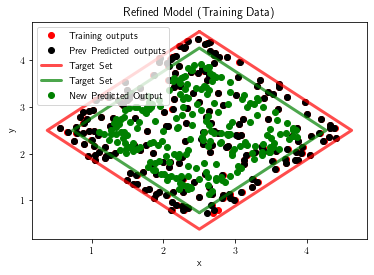

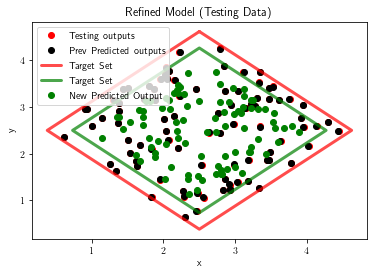

In [296]:
# ## training input
# plt.plot(x_train[:, 0], x_train[:, 1], 'bo', label='Input Sample')
# x_poly, y_poly = poly.exterior.xy
# plt.plot(x_poly, y_poly, color='blue', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

## predicted output (training)
x_poly_2, y_poly_2 = poly2.exterior.xy
plt.plot(y_train[:, 0], Y_orig_train[:, 1], 'ro', label='Training outputs')
plt.plot(y_predict_train[:, 0], y_predict_train[:, 1], 'ko', label='Prev Predicted outputs')
plt.plot(x_poly_2, y_poly_2, color='red', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Target Set')
plt.plot(x_poly3, y_poly3, color='green', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Target Set')
plt.plot(y_new2_train_rep[:, 0], y_new2_train_rep[:, 1], 'go', label='New Predicted Output')
plt.title('Refined Model (Training Data)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc="upper left")
plt.show()

# ## testing input
# plt.plot(x_test[:, 0], x_test[:, 1], 'bo', label='Input Sample')
# x_poly, y_poly = poly.exterior.xy
# plt.plot(x_poly, y_poly, color='blue', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

## predicted output (testing)
x_poly_2, y_poly_2 = poly2.exterior.xy
plt.plot(y_test[:, 0], y_test[:, 1], 'ro', label='Testing outputs')
plt.plot(y_predict_test[:, 0], y_predict_test[:, 1], 'ko', label='Prev Predicted outputs')
plt.plot(x_poly_2, y_poly_2, color='red', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Target Set')
plt.plot(x_poly3, y_poly3, color='green', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Target Set')
plt.plot(y_new2_test_rep[:, 0], y_new2_test_rep[:, 1], 'go', label='New Predicted Output')
plt.title('Refined Model (Testing Data)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc="upper left")
plt.show()

In [297]:
MSE_original_nn_train = squared_sum(y_train, y_predict_train, num_samples, 2)/y_train.shape[0]
MSE_new_nn_train = squared_sum(y_train, y_new2_train_rep, num_samples, 2)/y_train.shape[0]
MSE_original_nn_test = squared_sum(y_test, y_predict_test, y_test.shape[0], 2)/y_test.shape[0]
MSE_new_nn_test = squared_sum(y_test, y_new2_test_rep, y_test.shape[0], 2)/y_test.shape[0]

from IPython.display import HTML, display
import tabulate
table = [["MSE","Training Data"," Testing Data"],
         ["Original NN",round(MSE_original_nn_train,5),round(MSE_original_nn_test,5)],
         ["Modified NN",round(MSE_new_nn_train,5),round(MSE_new_nn_test,5)]]
display(HTML(tabulate.tabulate(table, tablefmt='html')))

weight_error = np.linalg.norm(w1_new-w1_orig)
bias_error = np.linalg.norm(b1_new-b1_orig)
print("weight_error: {}".format(weight_error))
print("bias_error: {}".format(bias_error))

MSE,Training Data,Testing Data
Original NN,0.00015,4e-05
Modified NN,0.14184,0.1234


weight_error: 0.5023388523643161
bias_error: 0.599541549808176


### First Layer Repair

Repairing last layer $\mathbf{W}_{new}^2 \mathbf{x}^2 + \mathbf{b}_{new}^2 = \mathbf{y}$:

\begin{align}
       & \min_{\mathbf{W}^2,\mathbf{b}^2}
       & & \frac{1}{2}\sum^{N}_{n=1}|| \mathbf{y}(\mathbf{x}^2_n,\mathbf{W}^2,\mathbf{b}^2)-\mathbf{t}_n||^2_2, \\
       & \text{s.t.} & &   \mathbf{W}_{new}^2 \mathbf{x}^2 + \mathbf{b}_{new}^2 = \mathbf{y},\\
       & & & \mathbf{A}\mathbf{y}\leq b.
\end{align}

![repair_last_layer.jpg](repair_last_layer.jpg)

### Build 1 Layer MIP NN

#### classes

In [298]:
class MIPLayer:
    def __init__(self, model, uin, uout, w_orig, b_orig, param_bounds=(-1, 1)):
        model.nlayers = getattr(model, 'nlayers', 0)
        self.uin, self.uout = uin, uout
        
        w_l, b_l = 'w' + str(model.nlayers), 'b' + str(model.nlayers)
        
        setattr(model, w_l, pyo.Var(range(uin), range(uout), domain=pyo.Reals, bounds=param_bounds))
        setattr(model, b_l, pyo.Var(range(uout), domain=pyo.Reals, bounds=param_bounds))
        
        self.w = getattr(model, w_l)
        self.b = getattr(model, b_l)
        self.w_orig = w_orig
        self.b_orig = b_orig
        
        model.nlayers += 1
        self.model = model
        
    def __call__(self, x, shape, relu=False, output_bounds=(-1e1, 1e1)):
        self.model.lout = getattr(self.model, 'lout', 0) + 1
#         print(self.model.nlayers)
        if relu:
            return self._relu_constraints(x, shape, self.model.lout, output_bounds)
        return self._constraints(x, shape, self.model.lout, output_bounds)
    
    def _relu_constraints(self, x, shape, l, output_bounds=(-1e1, 1e1)):
        m, n = shape
        assert n == self.uin
        
        x_l, s_l, theta_l = 'x'+str(l), 's'+str(l), 'theta'+str(l)
        
        setattr(self.model, x_l, pyo.Var(range(m), range(self.uout), domain=pyo.NonNegativeReals, bounds=output_bounds))
        setattr(self.model, s_l, pyo.Var(range(m), range(self.uout), domain=pyo.NonNegativeReals, bounds=output_bounds))
        setattr(self.model, theta_l, pyo.Var(range(m), range(self.uout), domain=pyo.Binary))
        
        def constraints(model, i, j):
            product = self.b[j]
            for k in range(self.uin):
                product += x[i, k] * self.w[k, j]
            return product == getattr(model, x_l)[i, j] - getattr(model, s_l)[i, j]
        
        setattr(self.model, 'eq_constraint'+str(l),
                pyo.Constraint(range(m), range(self.uout), rule=constraints))
        
        def disjuncts(model, i, j):
            return [(getattr(model, theta_l)[i, j] == 0, getattr(model, x_l)[i, j] <= 0),
                    (getattr(model, theta_l)[i, j] == 1, getattr(model, s_l)[i, j] <= 0)]
        
        setattr(self.model, 'disjunction'+str(l), pyg.Disjunction(range(m), range(self.uout), rule=disjuncts))
        return  getattr(self.model, x_l)
        
    def _constraints(self, x, shape, l, output_bounds=(-1e1, 1e1), w_b_bound_error = 1):
        m, n = shape
        assert n == self.uin
        w_l = 'w'+str(l-1)
        b_l = 'b'+str(l-1)
        x_l = 'x'+str(l)
        setattr(self.model, x_l, pyo.Var(range(m), range(self.uout), domain=pyo.Reals, bounds=output_bounds))
        
        def constraints(model, i, j):
            product = self.b[j]
            for k in range(self.uin):
                product += x[i, k] * self.w[k, j]
            return product == getattr(model, x_l)[i, j]

#         def constraint_inside0(model, i):
#              return(-getattr(model, x_l)[i, 0] + getattr(model, x_l)[i, 1] - 2.121 <= 0)
        
#         def constraint_inside1(model, i):
#              return(getattr(model, x_l)[i, 0] + getattr(model, x_l)[i, 1] - 7.129 <= 0)
        
#         def constraint_inside2(model, i):
#              return(getattr(model, x_l)[i, 0] - getattr(model, x_l)[i, 1] - 2.123 <= 0)
       
#         def constraint_inside3(model, i):
#              return(-getattr(model, x_l)[i, 0] - getattr(model, x_l)[i, 1] + 2.887 <= 0)
        def constraint_inside0(model, i):
             return(A[0,0]*getattr(model, x_l)[i, 0] + A[0,1]*getattr(model, x_l)[i, 1] - b[0] <= 0)
        
        def constraint_inside1(model, i):
             return(A[1,0]*getattr(model, x_l)[i, 0] + A[1,1]*getattr(model, x_l)[i, 1] - b[1] <= 0)
        
        def constraint_inside2(model, i):
             return(A[2,0]*getattr(model, x_l)[i, 0] + A[2,1]*getattr(model, x_l)[i, 1] - b[2] <= 0)
       
        def constraint_inside3(model, i):
             return(A[3,0]*getattr(model, x_l)[i, 0] + A[3,1]*getattr(model, x_l)[i, 1] - b[3] <= 0)
        
        #def constraint_bound_w0(model, i, j):
            #return(getattr(model, w_l)[i, j]-self.w_orig[i,j] <= w_b_bound_error)
        
        #def constraint_bound_w1(model, i, j): 
            #return(getattr(model, w_l)[i, j]-self.w_orig[i,j] >= -w_b_bound_error)
        
        #def constraint_bound_b0(model, j):
           # return(getattr(model, b_l)[j]-self.b_orig[j] <= w_b_bound_error)
        
        #def constraint_bound_b1(model, j): 
            #return(getattr(model, b_l)[j]-self.b_orig[j] >= -w_b_bound_error)
       
        setattr(self.model, 'eq_constraint'+str(l),
                pyo.Constraint(range(m), range(self.uout), rule=constraints))
        setattr(self.model, 'keep_inside_constraint0'+str(l),
                 pyo.Constraint(range(m), rule=constraint_inside0))
        setattr(self.model, 'keep_inside_constraint1'+str(l),
                 pyo.Constraint(range(m), rule=constraint_inside1))
        setattr(self.model, 'keep_inside_constraint2'+str(l),
                 pyo.Constraint(range(m), rule=constraint_inside2))
        setattr(self.model, 'keep_inside_constraint3'+str(l),
                 pyo.Constraint(range(m), rule=constraint_inside3))
        
        e_w_l = 'e_w'+str(l)
        setattr(self.model, e_w_l, pyo.Var(within=pyo.NonNegativeReals, bounds=(0,5), initialize=0.1))

        #e_b_l = 'e_b'+str(l)
        #setattr(self.model, e_b_l, pyo.Var(within=pyo.NonNegativeReals, bounds=(0,1), initialize=0.1))

        def constraint_w_bound_up(model, k, j):
            return(self.w[k, j] - self.w_orig[k, j] <= getattr(model, e_w_l))
        def constraint_w_bound_down(model, k, j):
            return(self.w[k, j] - self.w_orig[k, j] >= -getattr(model, e_w_l))
        def constraint_b_bound_up(model, j):
            return(self.b[j] - self.b_orig[j] <= getattr(model, e_w_l))
        def constraint_b_bound_down(model, j):
            return(self.b[j] - self.b_orig[j] >= -getattr(model, e_w_l))

        setattr(self.model, 'constraint_w_bound_up'+str(l),
                pyo.Constraint(range(self.uin), range(self.uout), rule=constraint_w_bound_up))
        setattr(self.model, 'constraint_w_bound_down'+str(l),
                pyo.Constraint(range(self.uin), range(self.uout), rule=constraint_w_bound_down))
        setattr(self.model, 'constraint_b_bound_up'+str(l),
                pyo.Constraint(range(self.uout), rule=constraint_b_bound_up))
        setattr(self.model, 'constraint_b_bound_down'+str(l),
                pyo.Constraint(range(self.uout), rule=constraint_b_bound_down))
        #setattr(self.model, 'w_bounded_constraint0'+str(l),
                #pyo.Constraint(range(self.uin), range(self.uout), rule=constraint_bound_w0))
        #setattr(self.model, 'w_bounded_constraint1'+str(l),
                #pyo.Constraint(range(self.uin), range(self.uout), rule=constraint_bound_w1))
        #setattr(self.model, 'b_bounded_constraint0'+str(l),
                #pyo.Constraint(range(self.uout), rule=constraint_bound_b0))
        #setattr(self.model, 'b_bounded_constraint1'+str(l),
                #pyo.Constraint(range(self.uout), rule=constraint_bound_b1))
        
        return getattr(self.model, x_l)

In [299]:
class MIPNNModel:
    def __init__(self, uin, uout, uhidden, w2_orig, b2_orig, param_bounds=(-1, 1)):
        self.model = pyo.ConcreteModel()
        
        self.model.nlayers = 0
        
        self.uin, self.uout = uin, uout
        
        self.layers = []
        prev = uin
        for u in uhidden:
            self.layers.append(MIPLayer(self.model, prev, u, w2_orig, b2_orig, param_bounds))
            prev = u
        self.layers.append(MIPLayer(self.model, prev, uout, w2_orig, b2_orig, param_bounds))
        
    def __call__(self, x, shape, relu=False, output_bounds=(-1e1, 1e1)):
        m, n = shape
        assert n == self.uin
        
        for layer in self.layers[:-1]:
            x = layer(x, (m, layer.uin), relu=True, output_bounds=output_bounds)
        
        layer = self.layers[-1]
        y = layer(x, (m, layer.uin), relu=relu, output_bounds=output_bounds)
        return y

#### Building 1 Layer

In [300]:

num_samples = X1_new2_train_rep.shape[0]
mip_model_layer3 = MIPNNModel(num_hidden_1, num_output, [], w2_orig, b2_orig)
y_ = mip_model_layer3(X1_new2_train_rep, (num_samples, num_hidden_1))
#print(y_train)

model_lay3 = mip_model_layer3.model
#pprint(vars(model_lay3))
#print(mip_model_layer3.model.eq_constraint1[(0,0)])





#### Final Output and Ojbective

In [301]:
def squared_sum(x, y, m, n):
    _squared_sum = 0
    for i in range(m):
        for j in range(n):
            _squared_sum += (x[i, j] - y[i, j]) ** 2
    return _squared_sum

cost_expr = squared_sum(y_, y_train, num_samples, num_output) ## check correctness

# regularization term for weigts
#for j in range(num_output):
#    cost_expr += regularizer_rate*model_lay3.b0[j]**2
#    for i in range(num_hidden_1):
#        cost_expr += regularizer_rate*model_lay3.w0[i, j]**2

cost_expr += model_lay3.e_w1**2

model_lay3.obj = pyo.Objective(expr=cost_expr)
pyo.TransformationFactory('gdp.bigm').apply_to(model_lay3)
opt = pyo.SolverFactory('gurobi',solver_io="python")

opt.solve(model_lay3, tee=True)

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter LogFile to C:\Users\kmajd1\AppData\Local\Temp\tmpawtlxhcy.log
   Prev:   Default: 
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 1494 rows, 643 columns and 4377 nonzeros
Model fingerprint: 0x413509c3
Model has 631 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e-03, 3e+00]
  Objective range  [1e+00, 9e+00]
  QObjective range [2e+00, 2e+00]
  Bounds range     [1e+00, 1e+01]
  RHS range        [3e-03, 5e+00]
Presolve removed 423 rows and 0 columns
Presolve time: 0.02s
Presolved: 1071 rows, 1051 columns, 3939 nonzeros
Presolved model has 631 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 9
 AA' NZ     : 6.132e+03
 Factor NZ  : 1.230e+04 (roughly 1 MByte of memory)
 Factor Ops : 3.159e+05 (less than 1 second per iteration)
 Thre

{'Problem': [{'Name': 'unknown', 'Lower bound': 21.494971782902667, 'Upper bound': 21.494971782902667, 'Number of objectives': 1, 'Number of constraints': 1494, 'Number of variables': 643, 'Number of binary variables': 0, 'Number of integer variables': 0, 'Number of continuous variables': 643, 'Number of nonzeros': 4377, 'Sense': 1, 'Number of solutions': 1}], 'Solver': [{'Name': 'Gurobi 9.10', 'Status': 'ok', 'Wallclock time': 0.098052978515625, 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.'}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [302]:
# #print the model in to a file (can also be saved in an lp format model_lay3.write(XXX.lp))

# original_stdout = sys.stdout # Save a reference to the original standard output

# with open('last_layer_mip_model_w_bounded.txt', 'w') as f:
#     sys.stdout = f # Change the standard output to the file we created.
#     model_lay3.pprint()
#     sys.stdout = original_stdout # Reset the standard output to its original value

In [303]:
model_lay3.e_w1.display()

e_w1 : Size=1, Index=None
    Key  : Lower : Value             : Upper : Fixed : Stale : Domain
    None :     0 : 0.774663020646555 :     5 : False : False : NonNegativeReals


In [304]:
model_lay3.w0.display()

w0 : Size=9, Index=w0_index
    Key    : Lower : Value                  : Upper : Fixed : Stale : Domain
    (0, 0) :    -1 :    -0.6556441333035581 :     1 : False : False :  Reals
    (0, 1) :    -1 :     0.9587939722100125 :     1 : False : False :  Reals
    (0, 2) :    -1 : 1.9921809696121784e-05 :     1 : False : False :  Reals
    (1, 0) :    -1 :    -0.9999999439119628 :     1 : False : False :  Reals
    (1, 1) :    -1 :    -0.8090286691343683 :     1 : False : False :  Reals
    (1, 2) :    -1 :   0.002033399808344827 :     1 : False : False :  Reals
    (2, 0) :    -1 :     0.9999999999911304 :     1 : False : False :  Reals
    (2, 1) :    -1 :     0.5351894202960028 :     1 : False : False :  Reals
    (2, 2) :    -1 : 0.00023855833484809352 :     1 : False : False :  Reals


In [305]:
model_lay3.b0.display()

b0 : Size=3, Index=b0_index
    Key : Lower : Value               : Upper : Fixed : Stale : Domain
      0 :    -1 :  0.9999999999756861 :     1 : False : False :  Reals
      1 :    -1 : -0.2719761579647514 :     1 : False : False :  Reals
      2 :    -1 :  0.9993303286380837 :     1 : False : False :  Reals


In [306]:
print(w2_orig) #previously trained nn weights
print(b2_orig) #previously trained nn bias

[[-0.70399517  0.79542744  0.00331858]
 [-0.22533692 -0.3705961   0.28851905]
 [ 0.9938741   0.5087391   0.00939754]]
[ 1.1584313  -0.01351866  0.9685662 ]


In [307]:
model_lay3.x1.display()

x1 : Size=630, Index=x1_index
    Key      : Lower : Value              : Upper : Fixed : Stale : Domain
      (0, 0) : -10.0 : 2.5414709473902874 :  10.0 : False : False :  Reals
      (0, 1) : -10.0 :  3.663620364098602 :  10.0 : False : False :  Reals
      (0, 2) : -10.0 : 1.0001168606290651 :  10.0 : False : False :  Reals
      (1, 0) : -10.0 : 2.9260559348922026 :  10.0 : False : False :  Reals
      (1, 1) : -10.0 : 1.6514187984055138 :  10.0 : False : False :  Reals
      (1, 2) : -10.0 : 0.9999099801487343 :  10.0 : False : False :  Reals
      (2, 0) : -10.0 :  2.155618155688357 :  10.0 : False : False :  Reals
      (2, 1) : -10.0 : 1.2173112896753295 :  10.0 : False : False :  Reals
      (2, 2) : -10.0 : 0.9997232537773595 :  10.0 : False : False :  Reals
      (3, 0) : -10.0 :   2.49494069583465 :  10.0 : False : False :  Reals
      (3, 1) : -10.0 : 3.5937018856853573 :  10.0 : False : False :  Reals
      (3, 2) : -10.0 : 1.0000996996762161 :  10.0 : False : False :  R

In [184]:
print(Y_orig_train)

[[2.54401925 3.80668016 1.00851711]
 [3.24061182 1.4632898  0.9918013 ]
 [2.18005681 0.9048504  0.9816389 ]
 [2.48324545 3.72154244 1.00747616]
 [2.63840749 3.68648478 1.00795524]
 [2.17026091 4.10528143 1.00921137]
 [2.38478234 3.74851337 1.00721292]
 [2.25540444 1.91826284 0.99076489]
 [1.18969077 1.90033783 0.98524149]
 [1.10336502 2.04184497 0.98602791]
 [3.30594295 1.39295021 0.99152334]
 [3.04567427 3.64147567 1.00961845]
 [2.66773995 0.89898362 0.98404504]
 [3.7262506  3.21139094 1.00933504]
 [3.93347175 2.1481291  1.0012023 ]
 [3.39522229 3.20210089 1.00758726]
 [2.60671747 3.58183702 1.00689242]
 [2.87755419 2.13846007 0.99579951]
 [1.52434406 2.14519538 0.98904064]
 [2.88789174 4.0779369  1.01259055]
 [0.96286511 2.91292195 0.99283809]
 [1.2575133  1.96934822 0.98617876]
 [2.23075317 3.44488625 1.00381647]
 [1.7380262  1.22524375 0.98217731]
 [0.75388846 2.26872686 0.98622551]
 [2.77624499 4.07539158 1.01200614]
 [2.19018986 3.49322663 1.00402933]
 [1.40922745 3.07959219 0.99

In [308]:
y_new = np.zeros((num_samples, num_hidden_1))
w2_new = np.zeros((num_hidden_1, num_output))
b2_new = np.zeros((1, num_output))
for i in range(num_samples):
    for j in range(num_hidden_1):
        y_new[i, j] = model_lay3.x1[i, j].value
for j in range(num_output):
    b2_new[0, j] = model_lay3.b0[j].value
    for i in range(num_hidden_1):
        w2_new[i, j] = model_lay3.w0[i, j].value
print(w2_new)
print(b2_new)


[[-6.55644133e-01  9.58793972e-01  1.99218097e-05]
 [-9.99999944e-01 -8.09028669e-01  2.03339981e-03]
 [ 1.00000000e+00  5.35189420e-01  2.38558335e-04]]
[[ 1.         -0.27197616  0.99933033]]


#### Build Refined NN 

In [309]:
mlp_lay3 = MLP(num_input, num_output, [num_hidden_0, num_hidden_1])
mlp_lay3.layers[0].weights=w0_new   
mlp_lay3.layers[1].weights=w1_new  
mlp_lay3.layers[2].weights=w2_new  
mlp_lay3.layers[0].bias=b0_new
mlp_lay3.layers[1].bias=b1_new
mlp_lay3.layers[2].bias=b2_new

_, _, y_new_train = mlp_lay3(x_train, relu=False)
_, _, y_new_test = mlp_lay3(x_test, relu=False)

#### Plot New Results

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


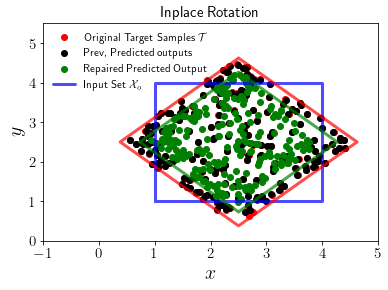

In [310]:
# ## training input
# plt.plot(x_train[:, 0], x_train[:, 1], 'bo', label='Input Sample')
# x_poly, y_poly = poly.exterior.xy
# plt.plot(x_poly, y_poly, color='blue', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

## predicted output (training)
x_poly_2, y_poly_2 = poly2.exterior.xy
plt.plot(y_train[:, 0], y_train[:, 1], 'ro', label='Original Target Samples $\mathcal{T}$')
plt.plot(y_predict_train[:, 0], y_predict_train[:, 1], 'ko', label='Prev, Predicted outputs')
plt.plot(y_new_train[:, 0], y_new_train[:, 1], 'go', label='Repaired Predicted Output')
plt.plot(x_poly, y_poly, color='blue', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Input Set $\mathcal{X}_o$')
plt.plot(x_poly_2, y_poly_2, color='red', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2 )
plt.plot(x_poly3, y_poly3, color='green', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)
plt.xlim([-1,5])
plt.ylim([0,5.5])
plt.title(r'Inplace Rotation',fontsize=15)
plt.xlabel('$x$',fontsize=20)
plt.ylabel('$y$',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc="upper left",frameon=False,fontsize=11)
plt.savefig('paper_data/affine_rotate/last_layer.eps', format='eps')
plt.show()

# ## testing input
# plt.plot(x_test[:, 0], x_test[:, 1], 'bo', label='Input Sample')
# x_poly, y_poly = poly.exterior.xy
# plt.plot(x_poly, y_poly, color='blue', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

## predicted output (testing)
# x_poly_2, y_poly_2 = poly2.exterior.xy
# plt.plot(y_test[:, 0], y_test[:, 1], 'ro', label='Original Samples')
# plt.plot(y_predict_test[:, 0], y_predict_test[:, 1], 'ko', label='Prev Predicted outputs')
# plt.plot(x_poly_2, y_poly_2, color='red', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Target Set')
# plt.plot(x_poly3, y_poly3, color='green', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Target Set')
# plt.plot(y_new_test[:, 0], y_new_test[:, 1], 'go', label='New Predicted Output')
# plt.title('Refined Model (Testing Data)')
# plt.xlabel('x')
# plt.ylabel('y')
# plt.legend(loc="upper left")
# plt.show()

In [311]:
MSE_original_nn_train = squared_sum(y_train, y_predict_train, num_samples, 2)/y_train.shape[0]
MSE_new_nn_train = squared_sum(y_train, y_new_train, num_samples, 2)/y_train.shape[0]
MSE_original_nn_test = squared_sum(y_test, y_predict_test, y_test.shape[0], 2)/y_test.shape[0]
MSE_new_nn_test = squared_sum(Y_orig_test, y_new_test, y_test.shape[0], 2)/y_test.shape[0]

from IPython.display import HTML, display
import tabulate
table = [["MSE","Training Data"," Testing Data"],
         ["Original NN",round(MSE_original_nn_train,5),round(MSE_original_nn_test,5)],
         ["Repaired NN (Last Layer)",round(MSE_new_nn_train,5),round(MSE_new_nn_test,5)]]
display(HTML(tabulate.tabulate(table, tablefmt='html')))

weight_error = np.linalg.norm(w2_new-w2_orig)
bias_error = np.linalg.norm(b2_new-b2_orig)
print("weight_error: {}".format(weight_error))
print("bias_error: {}".format(bias_error))

MSE,Training Data,Testing Data
Original NN,0.00015,4e-05
Repaired NN (Last Layer),0.0995,0.0915


weight_error: 0.9509249667912799
bias_error: 0.30470836315025795
